# 机器学习大作业

## 小组成员以及贡献比
#### 2111033 艾明旭 30%
#### 2111090 陈嘉乐 30%
#### 2112893 杨淇   15%
#### 2111211 王伯雅 15%
#### 2112615 张欣杰 10%

### 基础要求 使用简单的深度学习的方法对数据进行细胞类型聚类，得到多个亚群，完成实验报告（最好使用ipynb文件，包括但不限于代码、模型设计思路、模型架构图、聚类效果展示、实验分析等），并以csv文件提交最终的dataset1数据聚类结果（聚类编号从0到k，k为算法计算的k个潜在细胞群）。
### 中级要求 使用你的方法在dataset2上做实验，dataset2有真实的细胞类型标签，你可以对你的方法进行自我评估，并且分析结果，可以体现你的模型改进过程。展示你计算的Adjusted Rand Score指标。
### 高级要求 复杂网络或者复现论文
### 加分项 基础要求的结果会通过Adjusted Rand Score指标进行评分，排名靠前会有额外得分。

### 背景
现如今二代测序技术可以测得生物体大量的的组学数据信息，如基因组数据、转录组数据以及蛋白组
数据，其为了解生物体的调控机理提供了数据基础。
然而对于生物数据的标注一直是一个难题，对于转录组数据，其通常是来分析细胞群的marker基因来给细胞群体进行标注，但是这需要耗费大量的人力和财力 。机器学习为生物数据标注提供了很大的便捷，其可以通过一些算法（如最简单的层次聚类、Kmeans等）先为数据标注一个大致正确的伪标签，为后续生物学家进行真实细胞类型的标注提供了参考。
我们这次使用转录组数据作为数据集来完成这次任务，转录组数据本质上是一个稀疏矩阵X，其大小为
n*m，n代表细胞总数，m代表基因表达的数量，其本质是一个基因表达矩阵，X_ij代表第i个细胞在第j个基因
上的表达量。

## 基础要求
基本的神经网络的思路是我们要利用神经网络算法进行建模，这里需要我们进行数据的预处理，之后需要我们经过自编码器进行改造，最后我们对梯度进行一定的验证。我们的最终目标通过聚类来实现

## 对dataset1数据集进行预处理、降维等操作。

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
    
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        
        # 获取 decoder 输出
        x_reconstructed = self.decoder(encoded_data)
        
        # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
        
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity

#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X
    
    # 转换为np.array类型
    data = np.asarray(data)
    
    # 对数变换
    data = np.log1p(data)
    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
    
    return torch.tensor(data, dtype=torch.float)
    

import anndata
# 读取.h5ad文件
adata = anndata.read_h5ad('dataset1.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整

def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence * 0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

Epoch [10/300], Loss: 15216.7383, Reconstruction Loss: 1.1316, KL Divergence: 152156.0625
Epoch [20/300], Loss: 12046.7295, Reconstruction Loss: 1.0732, KL Divergence: 120456.5625
Epoch [30/300], Loss: 9801.7529, Reconstruction Loss: 1.0162, KL Divergence: 98007.3594
Epoch [40/300], Loss: 8163.6646, Reconstruction Loss: 0.9777, KL Divergence: 81626.8672
Epoch [50/300], Loss: 6934.1519, Reconstruction Loss: 0.9532, KL Divergence: 69331.9844
Epoch [60/300], Loss: 5990.9165, Reconstruction Loss: 0.9376, KL Divergence: 59899.7891
Epoch [70/300], Loss: 5253.6406, Reconstruction Loss: 0.9276, KL Divergence: 52527.1289
Epoch [80/300], Loss: 4667.6763, Reconstruction Loss: 0.9212, KL Divergence: 46667.5469
Epoch [90/300], Loss: 4194.4224, Reconstruction Loss: 0.9171, KL Divergence: 41935.0547
Epoch [100/300], Loss: 3806.3462, Reconstruction Loss: 0.9148, KL Divergence: 38054.3125
Epoch [110/300], Loss: 3484.1223, Reconstruction Loss: 0.9136, KL Divergence: 34832.0859
Epoch [120/300], Loss: 321

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
    
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        
        # 获取 decoder 输出
        x_reconstructed = self.decoder(encoded_data)
        
        # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
        
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity

#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X
    
    # 转换为np.array类型
    data = np.asarray(data)
    
    # 对数变换
    data = np.log1p(data)
    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
    
    return torch.tensor(data, dtype=torch.float)
    

import anndata
# 读取.h5ad文件
adata = anndata.read_h5ad('dataset1.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整

def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence * 0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

Epoch [10/300], Loss: 15216.7383, Reconstruction Loss: 1.1316, KL Divergence: 152156.0625
Epoch [20/300], Loss: 12046.7295, Reconstruction Loss: 1.0732, KL Divergence: 120456.5625
Epoch [30/300], Loss: 9801.7529, Reconstruction Loss: 1.0162, KL Divergence: 98007.3594
Epoch [40/300], Loss: 8163.6646, Reconstruction Loss: 0.9777, KL Divergence: 81626.8672
Epoch [50/300], Loss: 6934.1519, Reconstruction Loss: 0.9532, KL Divergence: 69331.9844
Epoch [60/300], Loss: 5990.9165, Reconstruction Loss: 0.9376, KL Divergence: 59899.7891
Epoch [70/300], Loss: 5253.6406, Reconstruction Loss: 0.9276, KL Divergence: 52527.1289
Epoch [80/300], Loss: 4667.6763, Reconstruction Loss: 0.9212, KL Divergence: 46667.5469
Epoch [90/300], Loss: 4194.4224, Reconstruction Loss: 0.9171, KL Divergence: 41935.0547
Epoch [100/300], Loss: 3806.3462, Reconstruction Loss: 0.9148, KL Divergence: 38054.3125
Epoch [110/300], Loss: 3484.1223, Reconstruction Loss: 0.9136, KL Divergence: 34832.0859
Epoch [120/300], Loss: 321

## **探索最佳K值**

**K均值聚类的“肘部法”**：

1. **K均值聚类（KMean：** * 使用`KMeans`算法进行聚类，尝试不同的K值（簇的数量。

2. **循环尝试不同的K值：** 通过循环，代码尝试在指定范围内的不K值。

3. **计算每个K值对应的Inertia：** 对于每个K值，使用K均值聚类算法进行聚类，并计算每个数据点到其最近簇中心的距离的平方和，这个值称为Inrtia。

4. **绘制肘部法图：** 将不同K值与对应的Inerti定最适合数据的簇的数量。

In [ ]:
# 尝试不同的K值
k_values = range(16, 25)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

# 绘制K值和inertia之间的关系图
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

**使用Calinski-Harabasz指数对K均值聚类进行评估：**

1. **K均值聚类（KMeans）：** 使用`KMeans`算法进行聚类，尝试不同的K值（簇的数量。

2. **循环尝试不同的K值：** 通过循环，代码尝试在指定范围内的不K值。

3. **计算每个K值对应的Calinski-Harabasz指数：** 对于每个K值，使用K均值聚类算法进行聚类，并计算Calinski-Harabasz指数。该指数通过簇内的数据点之间的方差与簇间的数据点之间的方差之比来度量聚类的紧密性和分离性。具体而言，指数值越高表示簇内方差相对较低，簇间方差相对较高，这是聚类效果好的指标。

4. **绘制Calinski-Harabasz指数图：** 将不同K值与对应的Calinski-Harabasz指定最适合数据的簇的数量。

d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

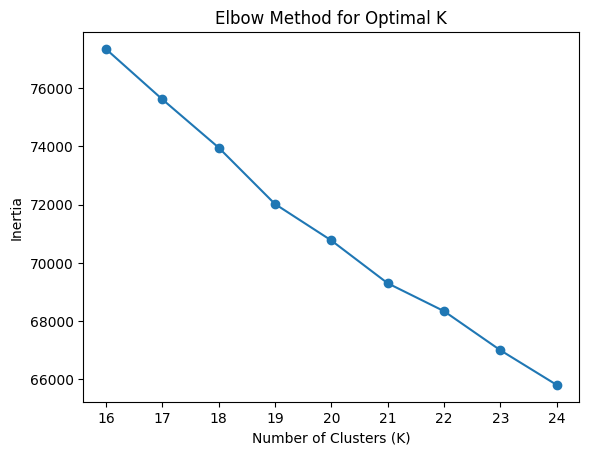

d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

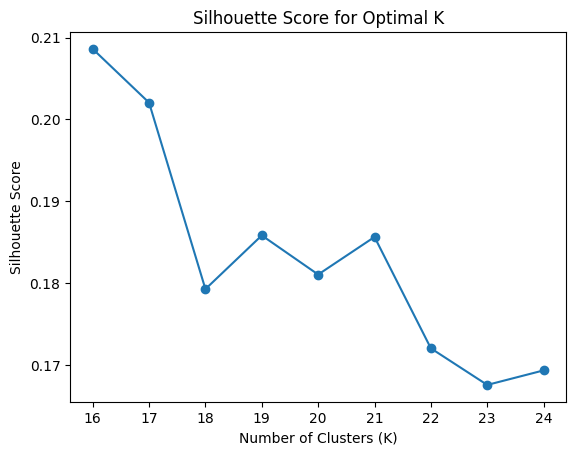

d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

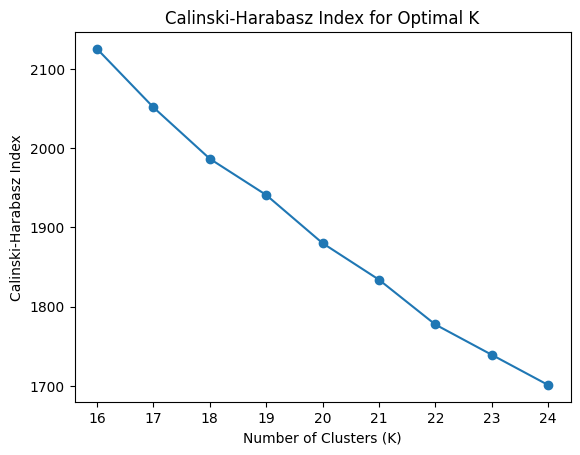

In [ ]:
# 尝试不同的K值
k_values = range(16, 25)
calinski_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    calinski_score = calinski_harabasz_score(data, cluster_labels)
    calinski_scores.append(calinski_score)

# 绘制K值和Calinski-Harabasz Index之间的关系图
plt.plot(k_values, calinski_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Optimal K')
plt.show()

这里我们可以看到对于两种方法并不能明显的得到最佳的K值选择。因此使用**轮廓系数**对K值再进行判断
**轮廓系数：**

1. **K均值聚类（KMeans）：** 使用`KMeans`算法进行聚类，尝试不同的K值（簇的数量。

2. **循环尝试不同的K值：** 通过循环，代码尝试在指定范围内的不K值。

3. **计算每个K值对应的轮廓系数：** 对于每个K值，使用K均值聚类算法进行聚类，并计算轮廓系数。轮廓系数度量了每个数据点与其同一簇内其他数据点相似度和与最近簇中的数据点相似度之间的关系。具体而言，轮廓系数的取值范围在[-1, 1]之间，较高的轮廓系数表示簇内相似度较高，簇间似度较低。

4. **绘制轮廓系数图：** 将不同K值与对应的轮廓系数。

我们可以在这里，你可以观察图表，找到轮廓系数变化趋势的峰值，以确定最适合数据的簇的数量。

d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

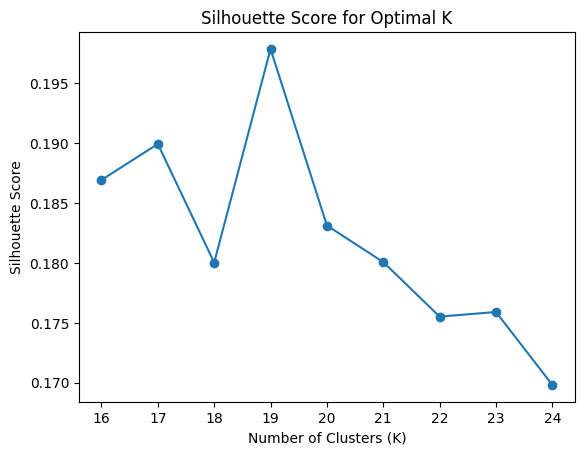

In [ ]:
# 尝试不同的K值
k_values = range(16, 25)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 绘制K值和轮廓系数之间的关系图
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

通过轮廓系数的方法我们找到了最佳的K值是19，因此将簇的个数设定为19，进行Kmeans聚类。聚类结果存储在cluster_labels中，并将这些标签添加到原始的Scanpy对象中，以便进一步的分析和可视化。

In [ ]:
# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 19  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data.data.numpy())

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


聚类结果统计信息:
cluster_labels
1     1136
10    1099
5      903
4      730
13     627
15     626
18     622
11     532
7      486
12     450
2      433
14     382
9      328
3      321
0      298
6      274
8      157
17     125
16     102
Name: count, dtype: int64


## 使用UMAP将经过降维的数据可视化


1. **PyTorch张量转换：** 将PyTorch张量 `encoded_data` 转换为NumPy数组 `encoded_data_np`。这是因为UMAP算法通常接受NumPy数组而不是PyTorch张。

2. **UMAP降维：** 使用UMAP（Uniform Manifold Approximation and Projection）算法将高维数据映射到二维空间。UMAP是一种非线性降维技术，用于可视化高维数据。在这里，`umap_model` 对象被创建，并通过 `fit_transform` 方法将高维数据 `encoded_data_np` 转换为二维UMAP空间中的坐标 `umap_daa`。

3. **设置图形风格：** 使用Seaborn库设置图形的风格，包括背景风格白色网格。

4. **绘制UMAP可视化图像：** 利用Seaborn和Matplotlib，绘制UMAP可视化图像。在图中，x轴和y轴表示UMAP的两个降维维度，点的颜色表示每个数据点所属的聚类标签，而点的透明度（alpha表示点的密度。

5. **显示图像：** 通过 `plt.show()` 将生成的UMAP理解数据的聚类和分布情况。

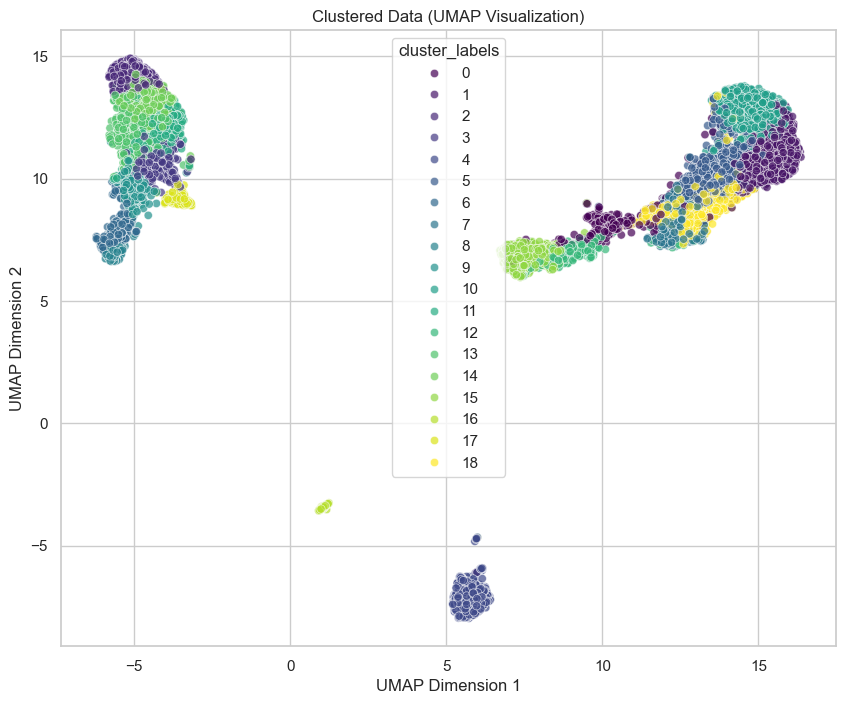

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 将 PyTorch 张量转换为 NumPy 数组
encoded_data_np = encoded_data.detach().numpy()

# 使用UMAP将高维数据映射到二维空间
umap_model = umap.UMAP()
umap_data = umap_model.fit_transform(encoded_data_np)

# 设置图形的风格
sns.set(style="whitegrid")

# 绘制UMAP可视化图像
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=adata.obs['cluster_labels'], palette='viridis', legend='full', alpha=0.7)
plt.title('Clustered Data (UMAP Visualization)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## 通过散点图可视化降维后的数据

1.  **设置图形风格：** 使用Seaborn库设置图形的风格，将背景样式设为白色网格。
2.  **绘制聚类结果图像：** 利用Seaborn和Matplotlib，绘制降维后数据的散点图。x轴和y轴表示降维后的两个维度，点的颜色表示每个数据点所属的聚类标签，而点的透明度（alpha）表示点的密度。
3.  **显示图像：** 通过 `plt.show()` 将生成的聚类结果图像显示出来。

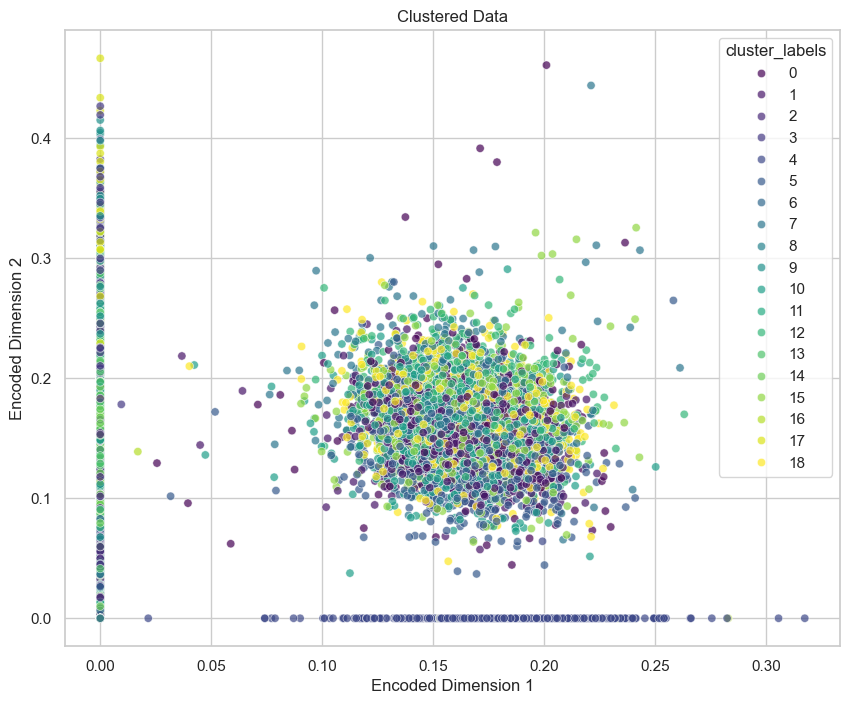

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形的风格
sns.set(style="whitegrid")

# 绘制聚类结果的图像
plt.figure(figsize=(10, 8))
sns.scatterplot(x=encoded_data_np[:, 0], y=encoded_data_np[:, 1], hue=adata.obs['cluster_labels'], palette='viridis', legend='full', alpha=0.7)
plt.title('Clustered Data')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.show()

## 将聚类结果以csv形式保存输出

In [ ]:
import pandas as pd

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 将数据存储到CSV文件
result_df = pd.DataFrame({
    'Cell_ID': adata.obs.index,  # 可根据你的数据调整Cell_ID列
    'Cluster_Labels': cluster_labels
})

result_df.to_csv('cluster_results.csv', index=False)

# **中级要求**

使用初级要求中改进的方法在dataset2上进行聚类，并将结果和dataset2的真实细胞类型标签进行比较，根据结果对程序进行优化。

**数据导入和处理：**

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
    
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        
        # 获取 decoder 输出
        x_reconstructed = self.decoder(encoded_data)
        
        # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
        
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity

#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X
    
    # 转换为np.array类型
    data = np.asarray(data)
    
    # 对数变换
    data = np.log1p(data)
    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
    
    return torch.tensor(data, dtype=torch.float)
    

import anndata
# 读取.h5ad文件
adata = anndata.read_h5ad('dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整

def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence * 0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

Epoch [10/300], Loss: 12134.7422, Reconstruction Loss: 0.4533, KL Divergence: 121342.8906
Epoch [20/300], Loss: 9821.9336, Reconstruction Loss: 0.4312, KL Divergence: 98215.0156
Epoch [30/300], Loss: 8148.1016, Reconstruction Loss: 0.4133, KL Divergence: 81476.8828
Epoch [40/300], Loss: 6922.6768, Reconstruction Loss: 0.3996, KL Divergence: 69222.7734
Epoch [50/300], Loss: 6005.4287, Reconstruction Loss: 0.3900, KL Divergence: 60050.3828
Epoch [60/300], Loss: 5301.7231, Reconstruction Loss: 0.3835, KL Divergence: 53013.3984
Epoch [70/300], Loss: 4746.8818, Reconstruction Loss: 0.3790, KL Divergence: 47465.0273
Epoch [80/300], Loss: 4296.7939, Reconstruction Loss: 0.3761, KL Divergence: 42964.1797
Epoch [90/300], Loss: 3922.3223, Reconstruction Loss: 0.3744, KL Divergence: 39219.4805
Epoch [100/300], Loss: 3604.1804, Reconstruction Loss: 0.3733, KL Divergence: 36038.0703
Epoch [110/300], Loss: 3329.1917, Reconstruction Loss: 0.3727, KL Divergence: 33288.1914
Epoch [120/300], Loss: 3088.

**通过轮廓系数得到最佳的K值**：

d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

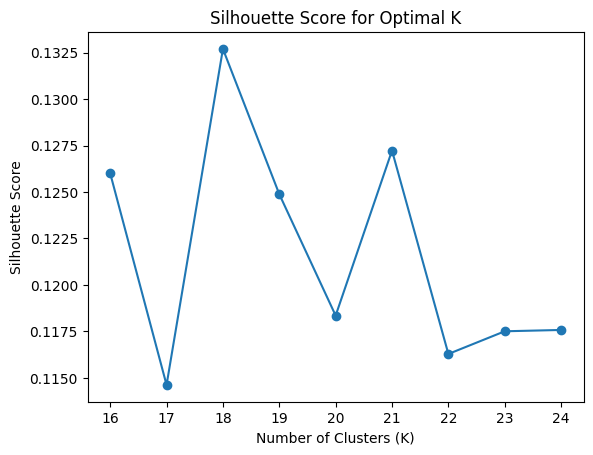

In [ ]:
# 尝试不同的K值
k_values = range(16, 25)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 绘制K值和轮廓系数之间的关系图
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

根据轮廓系数得到的K值，进行聚类，并将聚类的结果和dataset2的真实数据标签，“cell_type”进行对比，得到对应的Adjusted Rand Score值。

In [ ]:
# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 18  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data.data.numpy())

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

d:\python3_8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


聚类结果统计信息:
cluster_labels
4     998
16    694
0     694
6     683
10    640
11    619
5     604
13    568
3     544
8     490
12    469
1     412
15    406
14    386
17    310
9     286
7     254
2     133
Name: count, dtype: int64
Adjusted Rand Score: 0.3188


## 使用UMAP将经过降维的数据可视化

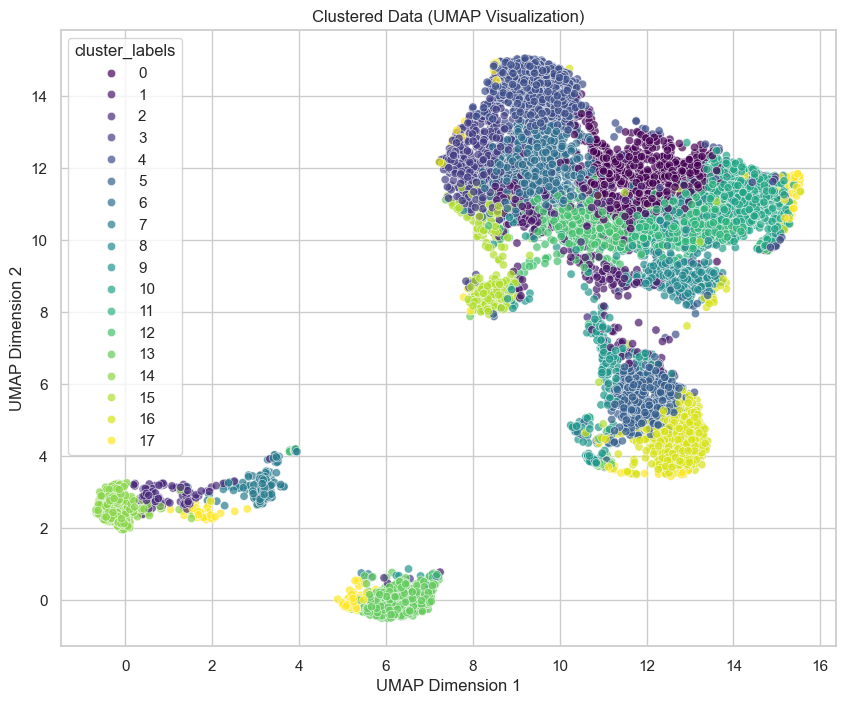

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 将 PyTorch 张量转换为 NumPy 数组
encoded_data_np = encoded_data.detach().numpy()

# 使用UMAP将高维数据映射到二维空间
umap_model = umap.UMAP()
umap_data = umap_model.fit_transform(encoded_data_np)

# 设置图形的风格
sns.set(style="whitegrid")

# 绘制UMAP可视化图像
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=adata.obs['cluster_labels'], palette='viridis', legend='full', alpha=0.7)
plt.title('Clustered Data (UMAP Visualization)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## 通过散点图可视化降维后的数据

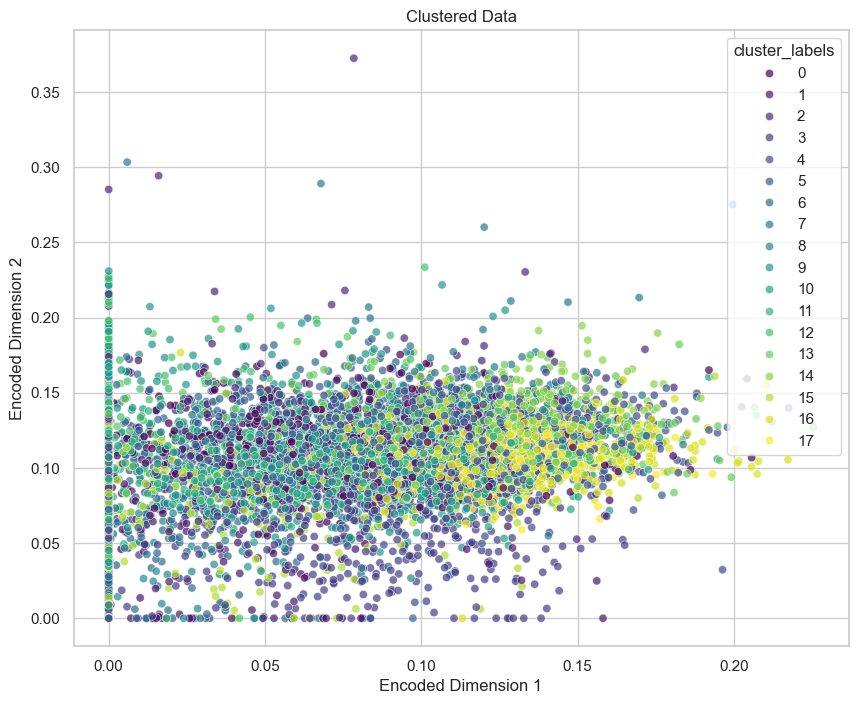

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形的风格
sns.set(style="whitegrid")

# 绘制聚类结果的图像
plt.figure(figsize=(10, 8))
sns.scatterplot(x=encoded_data_np[:, 0], y=encoded_data_np[:, 1], hue=adata.obs['cluster_labels'], palette='viridis', legend='full', alpha=0.7)
plt.title('Clustered Data')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.show()

## 高级要求优化算法

最终讨论结果如下

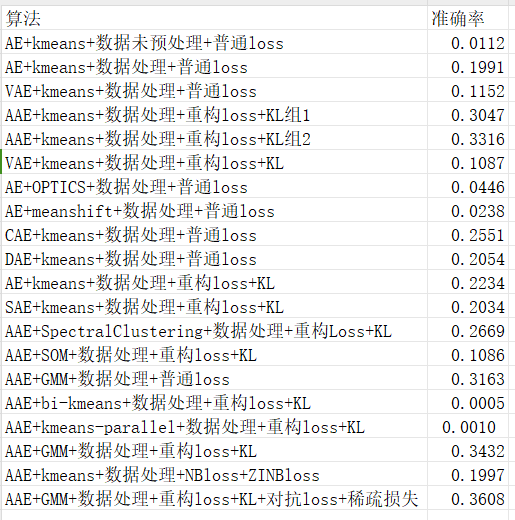

#### 数据的读取
导入了 scanpy 库并使用 sc 作为别名，方便后续代码中的调用。
通过 sc.read_h5ad 函数读取了一个单细胞RNA测序数据的文件（HDF5格式），并将数据存储在 annData 变量中。annData 是 AnnData 类型的对象，这是 scanpy 中用于存储单细胞数据的数据结构。
将 annData 转换为 pandas DataFrame 并打印出来。to_df() 方法将 AnnData 对象转换为 DataFrame，使得数据可以更容易地进行查看和分析。这一步是为了展示数据的内容，以便查看数据的结构和具体数值。



In [1]:
import scanpy as sc
annData = sc.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')
print(annData.to_df())

D:\newapp\anaconda\envs\pytorch\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
D:\newapp\anaconda\envs\pytorch\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
D:\newapp\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


genes                 0610005C13Rik  0610009B22Rik  0610009E02Rik  \
cells                                                               
09L_GTTAGAACAGAT_RNA            0.0            0.0            0.0   
09I_CATAGCTCAACG_RNA            0.0            0.0            0.0   
09G_TTACAGGCAGGT_RNA            0.0            0.0            0.0   
09B_CTATGGGCGTGC_RNA            0.0            0.0            0.0   
09L_AGTGATTGTTCG_RNA            0.0            0.0            0.0   
...                             ...            ...            ...   
09E_CCTGCTCGTCAC_RNA            0.0            0.0            0.0   
09E_TGAGCACCTCCT_RNA            0.0            0.0            0.0   
09E_CCGGACTCGATC_RNA            0.0            0.0            0.0   
09F_GCCCGACTCGCA_RNA            0.0            0.0            0.0   
09D_ATACTGCGCCCA_RNA            0.0            0.0            0.0   

genes                 0610009L18Rik  0610010F05Rik  0610030E20Rik  \
cells                            

### 对比没有预处理的结果
最开始我们并没有进行数据的预处理和关于更深层次算法的讨论，利用最常见的思路对本次实验进行了实现。
首先我们要转化为密集矩阵以进行聚类，之后我们将数据转换为pytorch张量。
之后我们开始使用了AE编码器，在下文将详细介绍。
参数这里，我们先设置为适应模型的要求，损失函数和优化器最开始我们设置为pytorch库里面的函数，之后进行模型的创建以及反向传播进行优化。得出结果后，我们利用第一问的结论进行kmeans聚类，并且将聚类后的结果利用Adjusted Rand Score这个值进行对比。

In [2]:
import torch
import torch.nn as nn
import scanpy as sc
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
# 读取H5AD文件
file_path = r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad'  # 替换为你的H5AD文件路径
adata = sc.read(file_path)
print(adata.obs_keys())
# 获取观测数据（样本数据）的NumPy数组
data_array = adata.X.toarray()  # 将稀疏矩阵转换为密集矩阵
# 将数据转换为PyTorch张量
data_tensor = torch.tensor(data_array, dtype=torch.float32)
# 定义简单的Autoencoder模型
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, encoding_size)
        self.decoder = nn.Linear(encoding_size, input_size)
    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.sigmoid(self.decoder(x))
        return x
# 设置模型参数
input_size = data_array.shape[1]
encoding_size = 500  # 调整编码器的大小，可以根据需要进行调整
# 创建Autoencoder模型
model = Autoencoder(input_size, encoding_size)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# 训练Autoencoder模型
num_epochs = 100  # 调整训练的轮数，可以根据需要进行调整
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(data_tensor)
    # 计算损失
    loss = criterion(outputs, data_tensor)
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 每10轮输出一次损失
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 使用Autoencoder进行降维
with torch.no_grad():
    encoded_data = model.encoder(data_tensor).numpy()

# 输出降维后的数据
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data)

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 可以通过以下方式输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# 也可以通过可视化查看聚类结果
#sc.pl.umap(adata, color='cluster_labels', legend_loc='on data', title='Clustered Data')

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # Replace 'true_labels' with the actual true labels if available
ari = adjusted_rand_score(true_labels, cluster_labels)

# Print the Adjusted Rand Score
print(f'Adjusted Rand Score: {ari:.4f}')

D:\newapp\anaconda\envs\pytorch\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


['domain', 'cell_type']
Epoch [10/100], Loss: 0.4563
Epoch [20/100], Loss: 0.4560
Epoch [30/100], Loss: 0.4556
Epoch [40/100], Loss: 0.4552
Epoch [50/100], Loss: 0.4549
Epoch [60/100], Loss: 0.4546
Epoch [70/100], Loss: 0.4544
Epoch [80/100], Loss: 0.4542
Epoch [90/100], Loss: 0.4540
Epoch [100/100], Loss: 0.4539
降维后的数据形状: (9190, 500)
聚类结果统计信息:
6     836
13    786
0     776
17    737
2     735
20    723
11    612
19    609
5     481
7     463
15    431
14    402
9     358
1     289
8     264
16    179
4     160
21    102
10    100
18     66
3      62
12     19
Name: cluster_labels, dtype: int64
Adjusted Rand Score: 0.0112


# 对自动编码器，降维方法，聚类方法，损失函数，网络层进行优化
### AE（Autoencoder）- 自动编码器：
区别： AE是一种无监督学习模型，由编码器和解码器组成。编码器将输入数据映射到潜在空间（编码），而解码器将潜在表示还原为输入数据（解码）。
应用场景： AE常用于数据降维、去噪、特征学习等任务。通过训练，AE可以学到输入数据的紧凑表示，捕捉数据中的主要特征。
### DAE（Denoising Autoencoder）- 去噪自动编码器：
区别： DAE是AE的变种，通过在输入中引入噪声来训练模型。模型需要还原原始未加噪声的数据，从而使其学到更健壮和有用的特征。
应用场景： DAE用于去除输入数据中的噪声，提高模型的鲁棒性，常用于去噪图像、去噪文本等任务。
### VAE（Variational Autoencoder）- 变分自动编码器：
区别： VAE引入了概率分布的概念，使编码的潜在空间更加连续和平滑。它通过最大化潜在表示的后验概率来训练，同时保持对样本的生成能力。
应用场景： VAE广泛应用于生成模型，例如生成新的图像、插值图像等。它还用于生成具有连续潜在表示的数据。
### AAE（Adversarial Autoencoder）- 对抗自动编码器：
区别： AAE结合了自动编码器和对抗性训练的思想，引入了对抗性损失，通过生成对抗性样本来提高模型的性能。
应用场景： AAE通常应用于生成对抗性样本，提高模型的鲁棒性，也可用于生成更具多样性的数据。
### SAE（Sparse Autoencoder）- 稀疏自动编码器：
区别： SAE在训练过程中引入了稀疏性的概念，即激活的神经元应该是稀疏的。这有助于学到更加有用和鲁棒的特征。
应用场景： SAE常用于特征学习，其中稀疏性有助于选择输入数据中最重要的特征。它还可以用于降噪和重建任务。
### CAE（Contractive Autoencoder）- 紧致自动编码器：
区别： CAE通过在损失函数中引入对输入空间的约束，使得编码器对输入的微小变化具有较小的响应，从而提高模型的稳定性。
应用场景： CAE可用于学习对输入数据中微小扰动不敏感的表示。它在对抗输入中的噪声和变化时表现良好，适用于一些对输入变化敏感的任务。
## 本次实验将依次对上述的编码器进行对比选择一个最好的结果

In [3]:
import scanpy as sc
# 读取H5AD文件
file_path = r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad'  # 替换为你的H5AD文件路径
adata = sc.read(file_path)
print(adata.obs_keys())
# 获取细胞类型标签和其对应的数量
cell_type_counts = adata.obs['cell_type'].value_counts()
# 输出每个细胞类型及其对应的数量
print("细胞类型及数量:")
print(cell_type_counts)

D:\newapp\anaconda\envs\pytorch\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


['domain', 'cell_type']
细胞类型及数量:
E2Rasgrf2     2254
E3Rorb        1443
E6Tle4        1186
E4Il1rapl2     620
E5Galnt14      532
E4Thsd7a       470
Ast            444
E5Parm1        345
InP            274
OliM           270
E3Rmst         231
E5Sulf1        223
InS            206
Clau           146
InV            129
InN            100
OPC             98
E5Tshz2         85
Mic             63
OliI            30
Endo            22
Peri            19
Name: cell_type, dtype: int64


### 数据预处理
数据预处理这里我们使用了相应的pre_data函数，这个函数里我们定义了稀疏矩阵转换为密集矩阵的函数。之后我们转换上述结果为np.array类型，有助于后续的数据处理和分析。接下来进行对数变换，通过使用 np.log1p 函数，可以有效地减小数据中较大值的影响，使得整体数据更接近正态分布。接下来我们运用了标准化函数，将数据转换为均值为0、标准差为1的分布。这有助于消除不同特征之间的量纲差异，确保模型在训练过程中更稳定，尤其是对于依赖于距离度量的模型（如PCA）。之后我们进行数据的归一化，将数据缩放到一个特定的范围（通常是[0, 1]）。这有助于处理不同特征之间的数值范围差异，确保模型不会受到数值范围较大或较小特征的影响。最后我们进行了PCA降维，通过线性变换将原始数据映射到新的特征空间，从而降低数据的维度。这有助于去除冗余信息，提取主要特征，减小计算复杂度，并有助于可视化。参数 n_components 指定了降维后的特征数量。

### 降维方法的对比
##### PCA（Principal Component Analysis）:
区别： PCA是一种线性降维方法，通过找到数据中方差最大的方向来进行降维。它的主成分是数据中方差最大的线性组合。
应用场景： PCA适用于线性结构的数据，对于高维数据中的冗余信息有较好的去除效果。常用于特征提取、去噪和数据可视化。
##### LLE（Locally Linear Embedding）:
区别： LLE是一种非线性降维方法，它在降维过程中保持数据局部的线性关系。它首先在每个数据点附近构建局部线性关系，然后在降维后保持这些关系。
应用场景： LLE适用于捕捉数据中的非线性结构，尤其在流形学习和局部结构保持方面表现出色。常用于图像处理、人脸识别等领域。
##### UMAP（Uniform Manifold Approximation and Projection）:
区别： UMAP是一种近似流形学习的降维方法，它通过优化保持数据点在降维空间中的邻域关系。UMAP在保持全局和局部结构上都有较好的表现。
应用场景： UMAP适用于高维数据中的非线性结构，尤其在聚类和可视化方面表现出色。常用于生物信息学、文本分析等领域。
### 总结：

线性 vs. 非线性： PCA是线性方法，适用于线性结构的数据；LLE和UMAP是非线性方法，适用于更复杂的数据结构。
局部关系 vs. 全局结构： LLE注重保持局部线性关系，适用于局部结构复杂的数据；UMAP在全局和局部都有较好的保持结构的能力。
计算复杂度： PCA计算相对较快；LLE和UMAP的计算复杂度较高，尤其是在大规模高维数据上。
应用场景：

如果数据结构是线性的且计算效率较为重要，可以考虑使用PCA。
对于非线性结构且局部关系较为重要的数据，LLE可能更合适。
UMAP在对全局和局部结构都敏感的情况下，常被选择用于高维数据的降维和可视化。
### 本次实验当中使用UMAP和LLE的结果都很差，所以我们最终使用了PCA作为降维的函数

In [59]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim


# 忽略所有警告
warnings.filterwarnings("ignore")

# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        # 添加噪声到输入数据
        noise = torch.randn_like(x) * 0.15  # 调整噪声水平
        x_noisy = x + noise

        # 编码器
        encoded = self.encoder(x_noisy)

        # 解码器
        decoded = self.decoder(encoded)

        return decoded,encoded

class ShrinkAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ShrinkAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True),
            nn.Linear(encoding_dim, encoding_dim-1),  # 添加一个维度减小的层
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim -1, encoding_dim),  # 对应于编码器中维度减小的层
            nn.ReLU(True),
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class VAE(nn.Module):
    def __init__(self, input_dim,encoding_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
#         # 编码器
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.ReLU(),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Linear(256, encoding_dim)
#         )

#         # 解码器
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, 512),
#             nn.ReLU(),
#             nn.Linear(512, input_dim),
#             nn.Sigmoid()  # 如果输入范围在 [0, 1] 之间，使用 Sigmoid
#         )
        
        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
    def forward(self, x):
        # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X    
    # 转换为np.array类型
    data = np.asarray(data)    
    # 对数变换
    data = np.log1p(data)    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
    # lle降维
    # lle = LocallyLinearEmbedding(n_components=n_components)
    # data = lle.fit_transform(data)
    # umap_model = umap.UMAP(n_components=n_components)
    # data = umap_model.fit_transform(data)   
    return torch.tensor(data, dtype=torch.float)
    

import anndata
# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
def calculate_mu_logvar(encoded):
    # 假设 encoded 是一个二维张量，每行对应一个样本的编码
    # 可以根据你的实际情况调整维度和操作

    # 计算均值和方差
    mu = torch.mean(encoded, dim=0)
    logvar = torch.log(torch.var(encoded, dim=0))

    return mu, logvar
def vae_loss(x_recon, x, mu, logvar):
    # 计算重建误差
    reconstruction_loss = criterion(x_recon, x)
    # 计算KL散度
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence*0.1
def calculate_kl_divergence(mu, logvar):
    # 计算 KL 散度的具体实现
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence
def custom_loss(output, data, mu, logvar):
    reconstruction_loss = criterion(output, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 假设有一个计算 KL 散度的函数    
    # 权衡重建误差和 KL 散度，可以根据需要调整权重
    loss = reconstruction_loss + 0.1 * kl_divergence    
    return loss

# 初始化模型
autoencoder = VAE(input_dim=input_dim, encoding_dim=encoding_dim)
# autoencoder = ShrinkAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# 训练模型
num_epochs = 300
reconstruction_loss_weight = 1.0
kl_divergence_weight = 0.1
for epoch in range(num_epochs):
    # # 前向传播
    # decoded, encoded = autoencoder(data)
    # mu, logvar = calculate_mu_logvar(encoded)
    # # 计算 KL 散度
    # kl_divergence = calculate_kl_divergence(mu,encoded)
    # # 计算重建误差
    # reconstruction_loss = criterion(decoded, data)
    # # 计算最终损失
    # loss = reconstruction_loss_weight * reconstruction_loss + kl_divergence_weight * kl_divergence
    # #loss = custom_loss(output, data, mu, logvar)
    # 前向传播
    x_recon, mu, logvar = autoencoder(data)

    # 计算损失
    loss = vae_loss(x_recon, data, mu, logvar)

    # # 反向传播和优化
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()    
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 使用编码器部分的权重进行聚类
autoencoder.eval()
encoded_data = autoencoder.encoder(data).data.numpy()

# 输出降维后的数据
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data)
# from sklearn.cluster import OPTICS

# # 创建并拟合OPTICS模型
# optics = OPTICS()
# cluster_labels = optics.fit_predict(encoded_data)

# # 获取簇的数量
# num_clusters = len(np.unique(cluster_labels))
# print(f"Number of clusters: {num_clusters}")
# from sklearn.cluster import MeanShift

# # 创建Mean Shift模型
# mean_shift = MeanShift()

# # 使用Mean Shift对数据进行聚类
# cluster_labels = mean_shift.fit_predict(encoded_data)
# print("Cluster Labels:", cluster_labels)
# num_clusters = len(set(cluster_labels))
# print(f"Number of clusters: {num_clusters}")
# from sklearn.mixture import GaussianMixture

# # 创建并拟合GMM模型
# gmm = GaussianMixture(n_components=num_clusters, random_state=42)
# cluster_labels = gmm.fit_predict(encoded_data)

# # 获取簇的数量
# num_clusters = len(np.unique(cluster_labels))
# print(f"Number of clusters: {num_clusters}")


# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels
# 计算UMAP
#sc.tl.umap(adata)
# 可以通过以下方式输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# 也可以通过可视化查看聚类结果
#sc.pl.umap(adata, color='cluster_labels', legend_loc='on data', title='Clustered Data')

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # Replace 'true_labels' with the actual true labels if available
ari = adjusted_rand_score(true_labels, cluster_labels)

# Print the Adjusted Rand Score
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 812.5966
Epoch [20/300], Loss: 420.7211
Epoch [30/300], Loss: 266.8281
Epoch [40/300], Loss: 184.6460
Epoch [50/300], Loss: 136.7886
Epoch [60/300], Loss: 106.5948
Epoch [70/300], Loss: 86.4393
Epoch [80/300], Loss: 71.7154
Epoch [90/300], Loss: 60.5704
Epoch [100/300], Loss: 51.8643
Epoch [110/300], Loss: 44.9027
Epoch [120/300], Loss: 39.2318
Epoch [130/300], Loss: 34.5448
Epoch [140/300], Loss: 30.6237
Epoch [150/300], Loss: 27.3090
Epoch [160/300], Loss: 24.4825
Epoch [170/300], Loss: 22.0571
Epoch [180/300], Loss: 19.9625
Epoch [190/300], Loss: 18.1414
Epoch [200/300], Loss: 16.5496
Epoch [210/300], Loss: 15.1520
Epoch [220/300], Loss: 13.9173
Epoch [230/300], Loss: 12.8221
Epoch [240/300], Loss: 11.8468
Epoch [250/300], Loss: 10.9758
Epoch [260/300], Loss: 10.1944
Epoch [270/300], Loss: 9.4920
Epoch [280/300], Loss: 8.8586
Epoch [290/300], Loss: 8.2858
Epoch [300/300], Loss: 7.7665
降维后的数据形状: (9190, 128)
聚类结果统计信息:
7     1241
2      996
10     954
3      673
1

### 之后我们首先尝试了VAE的kmeans聚类结果，得出的结果大致是0.1152，VAE的重点在于利用均值和方差实现了变分

### 接下来我们使用了AAE的kmeans聚类结果，损失函数采用了重构损失和KL损失的加权和，第一次测试就取得了不错的效果，结果最开始是0.3047

In [76]:
import torch.nn.functional as F
class VAE(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, encoding_dim)
        self.fc21 = nn.Linear(encoding_dim, encoding_dim)
        self.fc22 = nn.Linear(encoding_dim, encoding_dim)
        self.fc3 = nn.Linear(encoding_dim, input_dim)
        self.fc4 = nn.Linear(input_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.relu(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 100))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )
        
         # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        # 编码器
        encoded_data = self.encoder(x)

        # 提取均值和方差
        mu = self.fc_mu(encoded_data)
        logvar = self.fc_logvar(encoded_data)
        #z = mu + eps * std
        # 重新参数化技巧
        z = self.reparameterize(mu, logvar)

        # 解码器
        x_reconstructed = self.decoder(z)

        # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)

        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity
    
#     def forward(self, x):
#         # 获取 encoder 输出
#         encoded_data = self.encoder(x)        
#         # 获取 decoder 输出
#         x_reconstructed = self.decoder(encoded_data)        
#         # 获取 discriminator 输出
#         validity = self.discriminator(encoded_data)
        
#         # 返回一个包含三个元素的元组
#         return x_reconstructed, encoded_data, validity

# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整

def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence*0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data.data.numpy())

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')


Epoch [10/300], Loss: 12996.3145, Reconstruction Loss: 0.4232, KL Divergence: 129958.9141
Epoch [20/300], Loss: 10554.7500, Reconstruction Loss: 0.3326, KL Divergence: 105544.1719
Epoch [30/300], Loss: 8781.4160, Reconstruction Loss: 0.3120, KL Divergence: 87811.0469
Epoch [40/300], Loss: 7462.8496, Reconstruction Loss: 0.3057, KL Divergence: 74625.4375
Epoch [50/300], Loss: 6453.8945, Reconstruction Loss: 0.3052, KL Divergence: 64535.8906
Epoch [60/300], Loss: 5662.5977, Reconstruction Loss: 0.3045, KL Divergence: 56622.9297
Epoch [70/300], Loss: 5029.4854, Reconstruction Loss: 0.3047, KL Divergence: 50291.8047
Epoch [80/300], Loss: 4512.7378, Reconstruction Loss: 0.3059, KL Divergence: 45124.3164
Epoch [90/300], Loss: 4083.2441, Reconstruction Loss: 0.3059, KL Divergence: 40829.3828
Epoch [100/300], Loss: 3720.2349, Reconstruction Loss: 0.3064, KL Divergence: 37199.2852
Epoch [110/300], Loss: 3409.5200, Reconstruction Loss: 0.3073, KL Divergence: 34092.1250
Epoch [120/300], Loss: 314

之后我们对上述代码重新进行了一组测试，得到了更好的结果是：
### 0.3316

In [77]:
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        
    def forward(self, x):
         # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
   

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(encoded_data)
        logvar = self.fc_logvar(encoded_data)

        #  重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # 获取 decoder 输出
        x_reconstructed = self.decoder(z)
    
          # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
    
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity



def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    


# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence*0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data.data.numpy())

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 12145.6416, Reconstruction Loss: 0.4633, KL Divergence: 121451.7812
Epoch [20/300], Loss: 9806.5713, Reconstruction Loss: 0.3500, KL Divergence: 98062.2188
Epoch [30/300], Loss: 8126.8135, Reconstruction Loss: 0.3149, KL Divergence: 81264.9844
Epoch [40/300], Loss: 6902.9805, Reconstruction Loss: 0.3069, KL Divergence: 69026.7344
Epoch [50/300], Loss: 5984.8931, Reconstruction Loss: 0.3042, KL Divergence: 59845.8867
Epoch [60/300], Loss: 5274.6416, Reconstruction Loss: 0.3036, KL Divergence: 52743.3789
Epoch [70/300], Loss: 4708.5850, Reconstruction Loss: 0.3036, KL Divergence: 47082.8125
Epoch [80/300], Loss: 4245.5630, Reconstruction Loss: 0.3032, KL Divergence: 42452.5977
Epoch [90/300], Loss: 3858.4468, Reconstruction Loss: 0.3029, KL Divergence: 38581.4375
Epoch [100/300], Loss: 3528.9043, Reconstruction Loss: 0.3030, KL Divergence: 35286.0117
Epoch [110/300], Loss: 3245.6716, Reconstruction Loss: 0.3026, KL Divergence: 32453.6914
Epoch [120/300], Loss: 3001.

之后我们考虑VAE的正确率不理想是否是损失函数的问题，于是我们寻找到了VAE的损失函数，并且利用相应的损失函数进行了重新计算，但是最终的结果依然很不理想，因此我们放弃了对于VAE的使用

In [106]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim


# 忽略所有警告
warnings.filterwarnings("ignore")

# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        # 添加噪声到输入数据
        noise = torch.randn_like(x) * 0.15  # 调整噪声水平
        x_noisy = x + noise

        # 编码器
        encoded = self.encoder(x_noisy)

        # 解码器
        decoded = self.decoder(encoded)

        return decoded,encoded

class ShrinkAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ShrinkAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True),
            nn.Linear(encoding_dim, encoding_dim-1),  # 添加一个维度减小的层
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim -1, encoding_dim),  # 对应于编码器中维度减小的层
            nn.ReLU(True),
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class VAE(nn.Module):
    def __init__(self, input_dim,encoding_dim):
        super(VAE, self).__init__()
        # self.encoder = nn.Sequential(
        #     nn.Linear(input_dim, encoding_dim),
        #     nn.ReLU(True))
        # self.decoder = nn.Sequential(
        #     nn.Linear(encoding_dim, input_dim),
        #     nn.ReLU(True))
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # 如果输入范围在 [0, 1] 之间，使用 Sigmoid
        )
        
        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)

    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(0.5 * logvar)
    #     eps = torch.randn_like(std)
    #     return mu + eps * std

    def forward(self, x):
        # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    



#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X
    
    # 转换为np.array类型
    data = np.asarray(data)
    
    # 对数变换
    data = np.log1p(data)
    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
    # lle降维
    # lle = LocallyLinearEmbedding(n_components=n_components)
    # data = lle.fit_transform(data)
    # umap_model = umap.UMAP(n_components=n_components)
    # data = umap_model.fit_transform(data)   
    return torch.tensor(data, dtype=torch.float)
    

import anndata
# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
def calculate_mu_logvar(encoded):
    # 假设 encoded 是一个二维张量，每行对应一个样本的编码
    # 可以根据你的实际情况调整维度和操作

    # 计算均值和方差
    mu = torch.mean(encoded, dim=0)
    logvar = torch.log(torch.var(encoded, dim=0))

    return mu, logvar
def vae_loss(x_recon, x, mu, logvar):
    # 计算重建误差
    reconstruction_loss = criterion(x_recon, x)
    # 计算KL散度
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence*0.1
def calculate_kl_divergence(mu, logvar):
    # 计算 KL 散度的具体实现
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence
def custom_loss(output, data, mu, logvar):
    reconstruction_loss = criterion(output, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 假设有一个计算 KL 散度的函数    
    # 权衡重建误差和 KL 散度，可以根据需要调整权重
    loss = reconstruction_loss + 0.1 * kl_divergence    
    return loss

# 初始化模型
autoencoder = VAE(input_dim=input_dim, encoding_dim=encoding_dim)
# autoencoder = ShrinkAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# 训练模型
num_epochs = 300
reconstruction_loss_weight = 1.0
kl_divergence_weight = 0.1
for epoch in range(num_epochs):
    # # 前向传播
    # decoded, encoded = autoencoder(data)
    # mu, logvar = calculate_mu_logvar(encoded)
    # # 计算 KL 散度
    # kl_divergence = calculate_kl_divergence(mu,encoded)
    # # 计算重建误差
    # reconstruction_loss = criterion(decoded, data)
    # # 计算最终损失
    # loss = reconstruction_loss_weight * reconstruction_loss + kl_divergence_weight * kl_divergence
    # #loss = custom_loss(output, data, mu, logvar)
    # 前向传播
    x_recon, mu, logvar = autoencoder(data)

    # 计算损失
    loss = vae_loss(x_recon, data, mu, logvar)

    # # 反向传播和优化
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()    
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 使用编码器部分的权重进行聚类
autoencoder.eval()
encoded_data = autoencoder.encoder(data).data.numpy()

# 输出降维后的数据
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data)
# from sklearn.cluster import OPTICS

# # 创建并拟合OPTICS模型
# optics = OPTICS()
# cluster_labels = optics.fit_predict(encoded_data)

# # 获取簇的数量
# num_clusters = len(np.unique(cluster_labels))
# print(f"Number of clusters: {num_clusters}")
# from sklearn.cluster import MeanShift

# # 创建Mean Shift模型
# mean_shift = MeanShift()

# # 使用Mean Shift对数据进行聚类
# cluster_labels = mean_shift.fit_predict(encoded_data)
# print("Cluster Labels:", cluster_labels)
# num_clusters = len(set(cluster_labels))
# print(f"Number of clusters: {num_clusters}")
# from sklearn.mixture import GaussianMixture

# # 创建并拟合GMM模型
# gmm = GaussianMixture(n_components=num_clusters, random_state=42)
# cluster_labels = gmm.fit_predict(encoded_data)

# # 获取簇的数量
# num_clusters = len(np.unique(cluster_labels))
# print(f"Number of clusters: {num_clusters}")


# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels
# 计算UMAP
#sc.tl.umap(adata)
# 可以通过以下方式输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# 也可以通过可视化查看聚类结果
#sc.pl.umap(adata, color='cluster_labels', legend_loc='on data', title='Clustered Data')

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # Replace 'true_labels' with the actual true labels if available
ari = adjusted_rand_score(true_labels, cluster_labels)

# Print the Adjusted Rand Score
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 21.9428
Epoch [20/300], Loss: 7.3290
Epoch [30/300], Loss: 2.5536
Epoch [40/300], Loss: 1.4355
Epoch [50/300], Loss: 0.9737
Epoch [60/300], Loss: 0.8037
Epoch [70/300], Loss: 0.7100
Epoch [80/300], Loss: 0.6623
Epoch [90/300], Loss: 0.6362
Epoch [100/300], Loss: 0.6189
Epoch [110/300], Loss: 0.6054
Epoch [120/300], Loss: 0.5944
Epoch [130/300], Loss: 0.5851
Epoch [140/300], Loss: 0.5772
Epoch [150/300], Loss: 0.5702
Epoch [160/300], Loss: 0.5641
Epoch [170/300], Loss: 0.5587
Epoch [180/300], Loss: 0.5538
Epoch [190/300], Loss: 0.5495
Epoch [200/300], Loss: 0.5455
Epoch [210/300], Loss: 0.5419
Epoch [220/300], Loss: 0.5386
Epoch [230/300], Loss: 0.5355
Epoch [240/300], Loss: 0.5327
Epoch [250/300], Loss: 0.5302
Epoch [260/300], Loss: 0.5277
Epoch [270/300], Loss: 0.5255
Epoch [280/300], Loss: 0.5234
Epoch [290/300], Loss: 0.5215
Epoch [300/300], Loss: 0.5197
降维后的数据形状: (9190, 128)
聚类结果统计信息:
12    985
3     885
8     860
2     751
6     553
18    415
16    342
17    

#### CAE的验证
接下来我们进行了CAE的实现和验证，并且计算了准确率，CAE比较适合模拟微小变化下的聚类，尤其是分析大类里面的小类较为有优势，这次实验的结果也是比较不错的，用普通loss值也是有0.2551的准确率，但是依然不如AAE后续可以作为实验模型研究的一个方向。

In [105]:
import torch.nn.functional as F
class VAE(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, encoding_dim)
        self.fc21 = nn.Linear(encoding_dim, encoding_dim)
        self.fc22 = nn.Linear(encoding_dim, encoding_dim)
        self.fc3 = nn.Linear(encoding_dim, input_dim)
        self.fc4 = nn.Linear(input_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.relu(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 100))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )
        
         # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        # 编码器
        encoded_data = self.encoder(x)

        # 提取均值和方差
        mu = self.fc_mu(encoded_data)
        logvar = self.fc_logvar(encoded_data)
        #z = mu + eps * std
        # 重新参数化技巧
        z = self.reparameterize(mu, logvar)

        # 解码器
        x_reconstructed = self.decoder(z)

        # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)

        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity    

# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整

def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = ConvAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=0.0009)
num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence*0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = ConvAutoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data.data.numpy())

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 10982.1221, Reconstruction Loss: 0.4817, KL Divergence: 109816.4062
Epoch [20/300], Loss: 9060.1357, Reconstruction Loss: 0.3675, KL Divergence: 90597.6875
Epoch [30/300], Loss: 7627.4272, Reconstruction Loss: 0.3240, KL Divergence: 76271.0312
Epoch [40/300], Loss: 6547.7339, Reconstruction Loss: 0.3133, KL Divergence: 65474.2031
Epoch [50/300], Loss: 5716.2983, Reconstruction Loss: 0.3089, KL Divergence: 57159.8906
Epoch [60/300], Loss: 5061.2144, Reconstruction Loss: 0.3089, KL Divergence: 50609.0508
Epoch [70/300], Loss: 4533.7603, Reconstruction Loss: 0.3090, KL Divergence: 45334.5117
Epoch [80/300], Loss: 4100.5034, Reconstruction Loss: 0.3098, KL Divergence: 41001.9375
Epoch [90/300], Loss: 3737.6194, Reconstruction Loss: 0.3103, KL Divergence: 37373.0898
Epoch [100/300], Loss: 3429.0427, Reconstruction Loss: 0.3123, KL Divergence: 34287.3047
Epoch [110/300], Loss: 3162.9243, Reconstruction Loss: 0.3127, KL Divergence: 31626.1152
Epoch [120/300], Loss: 2931.

#### 去噪自编码器DAE的实现与验证
去噪自编码器比较适应于数据集当中存在噪声的情况，本次实验当中得到了0.2054的结果，反复验证后，最好的结果为0.2193，可见在本次实验当中虽然是一种优化，但是却并不是一个很好的结果

In [111]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim


# 忽略所有警告
warnings.filterwarnings("ignore")

# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        # 添加噪声到输入数据
        noise = torch.randn_like(x) * 0.15  # 调整噪声水平
        x_noisy = x + noise

        # 编码器
        encoded = self.encoder(x_noisy)

        # 解码器
        decoded = self.decoder(encoded)

        return decoded,encoded

class ShrinkAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ShrinkAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True),
            nn.Linear(encoding_dim, encoding_dim-1),  # 添加一个维度减小的层
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim -1, encoding_dim),  # 对应于编码器中维度减小的层
            nn.ReLU(True),
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class VAE(nn.Module):
    def __init__(self, input_dim,encoding_dim):
        super(VAE, self).__init__()
        # self.encoder = nn.Sequential(
        #     nn.Linear(input_dim, encoding_dim),
        #     nn.ReLU(True))
        # self.decoder = nn.Sequential(
        #     nn.Linear(encoding_dim, input_dim),
        #     nn.ReLU(True))
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # 如果输入范围在 [0, 1] 之间，使用 Sigmoid
        )
        
        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)

    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(0.5 * logvar)
    #     eps = torch.randn_like(std)
    #     return mu + eps * std

    def forward(self, x):
        # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    



#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X
    
    # 转换为np.array类型
    data = np.asarray(data)
    
    # 对数变换
    data = np.log1p(data)
    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
    # lle降维
    # lle = LocallyLinearEmbedding(n_components=n_components)
    # data = lle.fit_transform(data)
    # umap_model = umap.UMAP(n_components=n_components)
    # data = umap_model.fit_transform(data)   
    return torch.tensor(data, dtype=torch.float)
    

import anndata
# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
def calculate_mu_logvar(encoded):
    # 假设 encoded 是一个二维张量，每行对应一个样本的编码
    # 可以根据你的实际情况调整维度和操作

    # 计算均值和方差
    mu = torch.mean(encoded, dim=0)
    logvar = torch.log(torch.var(encoded, dim=0))

    return mu, logvar
def vae_loss(x_recon, x, mu, logvar):
    # 计算重建误差
    reconstruction_loss = criterion(x_recon, x)
    # 计算KL散度
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence*0.1
def calculate_kl_divergence(mu, logvar):
    # 计算 KL 散度的具体实现
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence
def custom_loss(output, data, mu, logvar):
    reconstruction_loss = criterion(output, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 假设有一个计算 KL 散度的函数    
    # 权衡重建误差和 KL 散度，可以根据需要调整权重
    loss = reconstruction_loss + 0.1 * kl_divergence    
    return loss

# 初始化模型
autoencoder = DenoisingAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
# autoencoder = ShrinkAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# 训练模型
num_epochs = 300
reconstruction_loss_weight = 1.0
kl_divergence_weight = 0.1
for epoch in range(num_epochs):
    # 前向传播
    decoded, encoded = autoencoder(data)
    mu, logvar = calculate_mu_logvar(encoded)
    # 计算 KL 散度
    kl_divergence = calculate_kl_divergence(mu,encoded)
    # 计算重建误差
    reconstruction_loss = criterion(decoded, data)
    # 计算最终损失
    #loss = reconstruction_loss_weight * reconstruction_loss + kl_divergence_weight * kl_divergence
    #loss = custom_loss(output, data, mu, logvar)
    #前向传播
    #decoded, mu, logvar = autoencoder(data)
    loss = criterion(decoded, data)
    # 计算损失
    #loss = vae_loss(x_recon, data, mu, logvar)
    # # 反向传播和优化
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()    
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 使用编码器部分的权重进行聚类
autoencoder.eval()
encoded_data = autoencoder.encoder(data).data.numpy()

# 输出降维后的数据
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data)
# from sklearn.cluster import OPTICS

# # 创建并拟合OPTICS模型
# optics = OPTICS()
# cluster_labels = optics.fit_predict(encoded_data)

# # 获取簇的数量
# num_clusters = len(np.unique(cluster_labels))
# print(f"Number of clusters: {num_clusters}")
# from sklearn.cluster import MeanShift

# # 创建Mean Shift模型
# mean_shift = MeanShift()

# # 使用Mean Shift对数据进行聚类
# cluster_labels = mean_shift.fit_predict(encoded_data)
# print("Cluster Labels:", cluster_labels)
# num_clusters = len(set(cluster_labels))
# print(f"Number of clusters: {num_clusters}")
# from sklearn.mixture import GaussianMixture

# # 创建并拟合GMM模型
# gmm = GaussianMixture(n_components=num_clusters, random_state=42)
# cluster_labels = gmm.fit_predict(encoded_data)

# # 获取簇的数量
# num_clusters = len(np.unique(cluster_labels))
# print(f"Number of clusters: {num_clusters}")


# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels
# 计算UMAP
#sc.tl.umap(adata)
# 可以通过以下方式输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# 也可以通过可视化查看聚类结果
#sc.pl.umap(adata, color='cluster_labels', legend_loc='on data', title='Clustered Data')

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # Replace 'true_labels' with the actual true labels if available
ari = adjusted_rand_score(true_labels, cluster_labels)

# Print the Adjusted Rand Score
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 0.4504
Epoch [20/300], Loss: 0.4067
Epoch [30/300], Loss: 0.3643
Epoch [40/300], Loss: 0.3252
Epoch [50/300], Loss: 0.2904
Epoch [60/300], Loss: 0.2623
Epoch [70/300], Loss: 0.2420
Epoch [80/300], Loss: 0.2298
Epoch [90/300], Loss: 0.2235
Epoch [100/300], Loss: 0.2201
Epoch [110/300], Loss: 0.2179
Epoch [120/300], Loss: 0.2162
Epoch [130/300], Loss: 0.2150
Epoch [140/300], Loss: 0.2141
Epoch [150/300], Loss: 0.2135
Epoch [160/300], Loss: 0.2131
Epoch [170/300], Loss: 0.2127
Epoch [180/300], Loss: 0.2125
Epoch [190/300], Loss: 0.2123
Epoch [200/300], Loss: 0.2120
Epoch [210/300], Loss: 0.2119
Epoch [220/300], Loss: 0.2118
Epoch [230/300], Loss: 0.2117
Epoch [240/300], Loss: 0.2115
Epoch [250/300], Loss: 0.2114
Epoch [260/300], Loss: 0.2113
Epoch [270/300], Loss: 0.2111
Epoch [280/300], Loss: 0.2107
Epoch [290/300], Loss: 0.2101
Epoch [300/300], Loss: 0.2095
降维后的数据形状: (9190, 128)
聚类结果统计信息:
2     1284
16    1217
0     1042
18     803
7      673
8      515
3      491


## 重构损失函数
我们重构了损失函数，有以下优点：
结合重建误差和KL散度：
该方法结合了两个关键方面：重建误差和KL散度。这使得损失函数不仅关注于保持输入数据的准确性（重建误差），还考虑了潜在空间中的分布情况（KL散度）。
重建误差：
重建误差衡量了模型生成的输出与原始输入数据的相似程度。通过最小化重建误差，模型被迫学习有效地表示输入数据，并在生成过程中保持数据的结构和特征。
KL散度：
KL散度用于衡量潜在空间中学到的分布与预定义的先验分布之间的差异。这对于VAE来说是重要的，因为它鼓励潜在表示更接近于标准正态分布，从而使潜在空间更加连续和可解释。
权重调整：
通过引入权重（reconstruction_loss_weight和kl_divergence_weight），可以调整两个损失项的相对重要性。这使得在训练过程中可以灵活地平衡重建和正则化项，以满足特定任务的需求。
梯度下降优化：
梯度下降优化算法可以用来最小化上述定义的损失函数。通过在训练过程中反向传播梯度并更新模型参数，可以使模型逐渐学到更好的数据表示和潜在分布。
潜在空间探索：
由于KL散度的存在，模型被鼓励在潜在空间中学到连续、平滑的表示。这使得在潜在空间中进行插值和探索更有意义，有助于生成具有多样性和连续性的样本。
接下来我们将重构损失函数对比到AE当中，发现也存在一定的优化，结果也能提升到0.2234

In [114]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim


# 忽略所有警告
warnings.filterwarnings("ignore")

# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        return y,x
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        # 添加噪声到输入数据
        noise = torch.randn_like(x) * 0.15  # 调整噪声水平
        x_noisy = x + noise

        # 编码器
        encoded = self.encoder(x_noisy)

        # 解码器
        decoded = self.decoder(encoded)

        return decoded,encoded

class ShrinkAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ShrinkAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True),
            nn.Linear(encoding_dim, encoding_dim-1),  # 添加一个维度减小的层
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim -1, encoding_dim),  # 对应于编码器中维度减小的层
            nn.ReLU(True),
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class VAE(nn.Module):
    def __init__(self, input_dim,encoding_dim):
        super(VAE, self).__init__()
        # self.encoder = nn.Sequential(
        #     nn.Linear(input_dim, encoding_dim),
        #     nn.ReLU(True))
        # self.decoder = nn.Sequential(
        #     nn.Linear(encoding_dim, input_dim),
        #     nn.ReLU(True))
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # 如果输入范围在 [0, 1] 之间，使用 Sigmoid
        )
        
        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)

    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(0.5 * logvar)
    #     eps = torch.randn_like(std)
    #     return mu + eps * std

    def forward(self, x):
        # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    



#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X
    
    # 转换为np.array类型
    data = np.asarray(data)
    
    # 对数变换
    data = np.log1p(data)
    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
    # lle降维
    # lle = LocallyLinearEmbedding(n_components=n_components)
    # data = lle.fit_transform(data)
    # umap_model = umap.UMAP(n_components=n_components)
    # data = umap_model.fit_transform(data)   
    return torch.tensor(data, dtype=torch.float)
    

import anndata
# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
def calculate_mu_logvar(encoded):
    # 假设 encoded 是一个二维张量，每行对应一个样本的编码
    # 可以根据你的实际情况调整维度和操作

    # 计算均值和方差
    mu = torch.mean(encoded, dim=0)
    logvar = torch.log(torch.var(encoded, dim=0))

    return mu, logvar
def vae_loss(x_recon, x, mu, logvar):
    # 计算重建误差
    reconstruction_loss = criterion(x_recon, x)
    # 计算KL散度
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence*0.1
def calculate_kl_divergence(mu, logvar):
    # 计算 KL 散度的具体实现
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence
def custom_loss(output, data, mu, logvar):
    reconstruction_loss = criterion(output, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 假设有一个计算 KL 散度的函数    
    # 权衡重建误差和 KL 散度，可以根据需要调整权重
    loss = reconstruction_loss + 0.1 * kl_divergence    
    return loss

# 初始化模型
autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
# autoencoder = ShrinkAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# 训练模型
num_epochs = 300
reconstruction_loss_weight = 1.0
kl_divergence_weight = 0.1
for epoch in range(num_epochs):
    # 前向传播
    decoded, encoded = autoencoder(data)
    mu, logvar = calculate_mu_logvar(encoded)
    # 计算 KL 散度
    kl_divergence = calculate_kl_divergence(mu,encoded)
    # 计算重建误差
    reconstruction_loss = criterion(decoded, data)
    # 计算最终损失
    #loss = reconstruction_loss_weight * reconstruction_loss + kl_divergence_weight * kl_divergence
    #loss = custom_loss(output, data, mu, logvar)
    #前向传播
    #decoded, mu, logvar = autoencoder(data)
    loss = criterion(decoded, data)
    # 计算损失
    #loss = vae_loss(x_recon, data, mu, logvar)
    # # 反向传播和优化
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()    
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 使用编码器部分的权重进行聚类
autoencoder.eval()
encoded_data = autoencoder.encoder(data).data.numpy()

# 输出降维后的数据
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data)
# from sklearn.cluster import OPTICS

# # 创建并拟合OPTICS模型
# optics = OPTICS()
# cluster_labels = optics.fit_predict(encoded_data)

# # 获取簇的数量
# num_clusters = len(np.unique(cluster_labels))
# print(f"Number of clusters: {num_clusters}")
# from sklearn.cluster import MeanShift

# # 创建Mean Shift模型
# mean_shift = MeanShift()

# # 使用Mean Shift对数据进行聚类
# cluster_labels = mean_shift.fit_predict(encoded_data)
# print("Cluster Labels:", cluster_labels)
# num_clusters = len(set(cluster_labels))
# print(f"Number of clusters: {num_clusters}")
# from sklearn.mixture import GaussianMixture

# # 创建并拟合GMM模型
# gmm = GaussianMixture(n_components=num_clusters, random_state=42)
# cluster_labels = gmm.fit_predict(encoded_data)

# # 获取簇的数量
# num_clusters = len(np.unique(cluster_labels))
# print(f"Number of clusters: {num_clusters}")


# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels
# 计算UMAP
#sc.tl.umap(adata)
# 可以通过以下方式输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# 也可以通过可视化查看聚类结果
#sc.pl.umap(adata, color='cluster_labels', legend_loc='on data', title='Clustered Data')

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # Replace 'true_labels' with the actual true labels if available
ari = adjusted_rand_score(true_labels, cluster_labels)

# Print the Adjusted Rand Score
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 0.4656
Epoch [20/300], Loss: 0.4257
Epoch [30/300], Loss: 0.3768
Epoch [40/300], Loss: 0.3342
Epoch [50/300], Loss: 0.2981
Epoch [60/300], Loss: 0.2697
Epoch [70/300], Loss: 0.2497
Epoch [80/300], Loss: 0.2364
Epoch [90/300], Loss: 0.2286
Epoch [100/300], Loss: 0.2238
Epoch [110/300], Loss: 0.2207
Epoch [120/300], Loss: 0.2187
Epoch [130/300], Loss: 0.2172
Epoch [140/300], Loss: 0.2160
Epoch [150/300], Loss: 0.2150
Epoch [160/300], Loss: 0.2139
Epoch [170/300], Loss: 0.2127
Epoch [180/300], Loss: 0.2117
Epoch [190/300], Loss: 0.2111
Epoch [200/300], Loss: 0.2107
Epoch [210/300], Loss: 0.2104
Epoch [220/300], Loss: 0.2102
Epoch [230/300], Loss: 0.2100
Epoch [240/300], Loss: 0.2098
Epoch [250/300], Loss: 0.2097
Epoch [260/300], Loss: 0.2096
Epoch [270/300], Loss: 0.2095
Epoch [280/300], Loss: 0.2094
Epoch [290/300], Loss: 0.2093
Epoch [300/300], Loss: 0.2093
降维后的数据形状: (9190, 128)
聚类结果统计信息:
4     1283
17    1144
20    1021
10     761
13     682
15     494
19     428


### SAE的计算结果与优化
SAE相对来说更适合大范围处理大规模数据，它的结果相对普通编码解码可能效果一般，但是在大规模计算当中有很好的发挥。这里使用了重构loss计算损失函数，最红我们的结果是0.2034

In [115]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim


# 忽略所有警告
warnings.filterwarnings("ignore")

# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        return y,x
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        # 添加噪声到输入数据
        noise = torch.randn_like(x) * 0.15  # 调整噪声水平
        x_noisy = x + noise

        # 编码器
        encoded = self.encoder(x_noisy)

        # 解码器
        decoded = self.decoder(encoded)

        return decoded,encoded

class ShrinkAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(ShrinkAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True),
            nn.Linear(encoding_dim, encoding_dim-1),  # 添加一个维度减小的层
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim -1, encoding_dim),  # 对应于编码器中维度减小的层
            nn.ReLU(True),
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        return y,x
    
class VAE(nn.Module):
    def __init__(self, input_dim,encoding_dim):
        super(VAE, self).__init__()
        # self.encoder = nn.Sequential(
        #     nn.Linear(input_dim, encoding_dim),
        #     nn.ReLU(True))
        # self.decoder = nn.Sequential(
        #     nn.Linear(encoding_dim, input_dim),
        #     nn.ReLU(True))
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # 如果输入范围在 [0, 1] 之间，使用 Sigmoid
        )
        
        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)

    # def reparameterize(self, mu, logvar):
    #     std = torch.exp(0.5 * logvar)
    #     eps = torch.randn_like(std)
    #     return mu + eps * std

    def forward(self, x):
        # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    



#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X
    
    # 转换为np.array类型
    data = np.asarray(data)
    
    # 对数变换
    data = np.log1p(data)
    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
    # lle降维
    # lle = LocallyLinearEmbedding(n_components=n_components)
    # data = lle.fit_transform(data)
    # umap_model = umap.UMAP(n_components=n_components)
    # data = umap_model.fit_transform(data)   
    return torch.tensor(data, dtype=torch.float)
    

import anndata
# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
def calculate_mu_logvar(encoded):
    # 假设 encoded 是一个二维张量，每行对应一个样本的编码
    # 可以根据你的实际情况调整维度和操作

    # 计算均值和方差
    mu = torch.mean(encoded, dim=0)
    logvar = torch.log(torch.var(encoded, dim=0))

    return mu, logvar
def vae_loss(x_recon, x, mu, logvar):
    # 计算重建误差
    reconstruction_loss = criterion(x_recon, x)
    # 计算KL散度
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence*0.1
def calculate_kl_divergence(mu, logvar):
    # 计算 KL 散度的具体实现
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence
def custom_loss(output, data, mu, logvar):
    reconstruction_loss = criterion(output, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 假设有一个计算 KL 散度的函数    
    # 权衡重建误差和 KL 散度，可以根据需要调整权重
    loss = reconstruction_loss + 0.1 * kl_divergence    
    return loss

# 初始化模型
#autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
autoencoder = ShrinkAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# 训练模型
num_epochs = 300
reconstruction_loss_weight = 1.0
kl_divergence_weight = 0.1
for epoch in range(num_epochs):
    # 前向传播
    decoded, encoded = autoencoder(data)
    mu, logvar = calculate_mu_logvar(encoded)
    # 计算 KL 散度
    kl_divergence = calculate_kl_divergence(mu,encoded)
    # 计算重建误差
    reconstruction_loss = criterion(decoded, data)
    # 计算最终损失
    #loss = reconstruction_loss_weight * reconstruction_loss + kl_divergence_weight * kl_divergence
    #loss = custom_loss(output, data, mu, logvar)
    #前向传播
    #decoded, mu, logvar = autoencoder(data)
    loss = criterion(decoded, data)
    # 计算损失
    #loss = vae_loss(x_recon, data, mu, logvar)
    # # 反向传播和优化
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()    
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 使用编码器部分的权重进行聚类
autoencoder.eval()
encoded_data = autoencoder.encoder(data).data.numpy()

# 输出降维后的数据
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data)
# from sklearn.cluster import OPTICS

# # 创建并拟合OPTICS模型
# optics = OPTICS()
# cluster_labels = optics.fit_predict(encoded_data)

# # 获取簇的数量
# num_clusters = len(np.unique(cluster_labels))
# print(f"Number of clusters: {num_clusters}")
# from sklearn.cluster import MeanShift

# # 创建Mean Shift模型
# mean_shift = MeanShift()

# # 使用Mean Shift对数据进行聚类
# cluster_labels = mean_shift.fit_predict(encoded_data)
# print("Cluster Labels:", cluster_labels)
# num_clusters = len(set(cluster_labels))
# print(f"Number of clusters: {num_clusters}")
# from sklearn.mixture import GaussianMixture

# # 创建并拟合GMM模型
# gmm = GaussianMixture(n_components=num_clusters, random_state=42)
# cluster_labels = gmm.fit_predict(encoded_data)

# # 获取簇的数量
# num_clusters = len(np.unique(cluster_labels))
# print(f"Number of clusters: {num_clusters}")


# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels
# 计算UMAP
#sc.tl.umap(adata)
# 可以通过以下方式输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# 也可以通过可视化查看聚类结果
#sc.pl.umap(adata, color='cluster_labels', legend_loc='on data', title='Clustered Data')

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # Replace 'true_labels' with the actual true labels if available
ari = adjusted_rand_score(true_labels, cluster_labels)

# Print the Adjusted Rand Score
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 0.4117
Epoch [20/300], Loss: 0.3027
Epoch [30/300], Loss: 0.2917
Epoch [40/300], Loss: 0.2832
Epoch [50/300], Loss: 0.2690
Epoch [60/300], Loss: 0.2552
Epoch [70/300], Loss: 0.2476
Epoch [80/300], Loss: 0.2440
Epoch [90/300], Loss: 0.2415
Epoch [100/300], Loss: 0.2396
Epoch [110/300], Loss: 0.2381
Epoch [120/300], Loss: 0.2368
Epoch [130/300], Loss: 0.2355
Epoch [140/300], Loss: 0.2345
Epoch [150/300], Loss: 0.2336
Epoch [160/300], Loss: 0.2329
Epoch [170/300], Loss: 0.2322
Epoch [180/300], Loss: 0.2317
Epoch [190/300], Loss: 0.2312
Epoch [200/300], Loss: 0.2309
Epoch [210/300], Loss: 0.2307
Epoch [220/300], Loss: 0.2306
Epoch [230/300], Loss: 0.2305
Epoch [240/300], Loss: 0.2304
Epoch [250/300], Loss: 0.2304
Epoch [260/300], Loss: 0.2303
Epoch [270/300], Loss: 0.2303
Epoch [280/300], Loss: 0.2302
Epoch [290/300], Loss: 0.2302
Epoch [300/300], Loss: 0.2302
降维后的数据形状: (9190, 127)
聚类结果统计信息:
12    1286
0     1257
11    1097
8      817
19     741
3      479
16     396


## 其他聚类方法的研究
K均值算法（K-means）:
算法： 将数据划分为K个簇，通过最小化数据点与簇中心的平方距离实现。
应用： 当簇的数量K已知，且簇呈球形且大小相等时广泛使用。
K均值++算法（K-means++）:
算法： 对K均值的改进，通过更有策略地初始化簇中心来减小对初始中心的敏感性。
应用： 在寻求更稳定和更快收敛的K均值算法时有用。
K均值||算法（K-means||）:
算法： 是K均值++的可扩展变体，通过并行地为大型数据集选择初始中心。
应用： 适用于需要并行化以提高效率的大型数据集。
双K均值算法（Bi-Kmeans）:
算法： 将K均值扩展到处理遵循双峰分布的数据，为每个簇分配两个中心。
应用： 在簇具有明显模式或处理混合模式数据时有用。
谱聚类算法（Spectral Clustering）:
算法： 利用相似性矩阵的特征向量在应用K均值或其他聚类算法之前进行降维。
应用： 适用于非凸簇和数据具有图形结构的情况。
层次聚类算法（Hierarchical Clustering）:
算法： 通过递归地合并或拆分现有簇来构建簇的层次结构。
应用： 当数据具有嵌套簇结构，且目标是在不同粒度水平上探索关系时使用。
DBSCAN算法（Density-Based Spatial Clustering of Applications with Noise）:
算法： 基于数据点密度形成簇，识别核心点并从核心点扩展簇。
应用： 适用于任意形状的簇，对噪声有良好处理，不需要预先指定簇的数量。
SOM： 
不需要预先指定簇的数量，可以捕捉非线性关系，对于复杂结构的数据有一定优势，通过拓扑结构保留了样本之间的空间关系。SOM在处理非线性、具有拓扑结构的数据上有一定优势。
本次实验当中，使用层次和DBSCAN聚类的结果都很差，因此我们采用kmeans聚类的多种变形进行本次实验

#### SpectralClustering聚类
这种聚类方法更实用与数据集较为平缓，不存在凸函数的情况，kmeans等相关的方法都较为适用于凸函数的情景，这里我们的数据集可能更加符合凸函数，因此本算法的应用结果不算好。最终的结果为0.2669，甚至是略差于kmeans。

In [120]:
from sklearn.cluster import SpectralClustering
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        
    def forward(self, x):
         # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
   

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(encoded_data)
        logvar = self.fc_logvar(encoded_data)

        #  重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # 获取 decoder 输出
        x_reconstructed = self.decoder(z)
    
          # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
    
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity



def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    


# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence*0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

spectral = SpectralClustering(n_clusters=num_clusters, random_state=42)
cluster_labels = spectral.fit_predict(encoded_data.data.numpy())

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 10692.7500, Reconstruction Loss: 0.4455, KL Divergence: 106923.0469
Epoch [20/300], Loss: 8693.3516, Reconstruction Loss: 0.3388, KL Divergence: 86930.1250
Epoch [30/300], Loss: 7249.3564, Reconstruction Loss: 0.3133, KL Divergence: 72490.4297
Epoch [40/300], Loss: 6183.0562, Reconstruction Loss: 0.3066, KL Divergence: 61827.4961
Epoch [50/300], Loss: 5372.4668, Reconstruction Loss: 0.3059, KL Divergence: 53721.6094
Epoch [60/300], Loss: 4738.8555, Reconstruction Loss: 0.3052, KL Divergence: 47385.5000
Epoch [70/300], Loss: 4229.6870, Reconstruction Loss: 0.3055, KL Divergence: 42293.8125
Epoch [80/300], Loss: 3810.5146, Reconstruction Loss: 0.3056, KL Divergence: 38102.0898
Epoch [90/300], Loss: 3459.2639, Reconstruction Loss: 0.3063, KL Divergence: 34589.5742
Epoch [100/300], Loss: 3160.7656, Reconstruction Loss: 0.3065, KL Divergence: 31604.5918
Epoch [110/300], Loss: 2904.6626, Reconstruction Loss: 0.3074, KL Divergence: 29043.5527
Epoch [120/300], Loss: 2683.

### SOM聚类
SOM聚类算法更适合用于图像识别等类似的算法，本次实验当中的数据集并不是很好的图像识别的样本，包括许多图像识别分类当中的较好的算法都没有在本次实验当中有一个很好的结果，这里以SOM算法为例，计算的准确率只有0.1087。由此本次实验当中很多在图像当中有优势的算法结果都很一般。

In [136]:
from sklearn.cluster import SpectralClustering
from minisom import MiniSom
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        
    def forward(self, x):
         # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
   

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(encoded_data)
        logvar = self.fc_logvar(encoded_data)

        #  重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # 获取 decoder 输出
        x_reconstructed = self.decoder(z)
    
          # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
    
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity



def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    


# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence*0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整
# 将数据转换为numpy数组
data_array = encoded_data.data.numpy()
# 定义 SOM 网络的大小，这里可以根据需要进行调整
som_rows, som_cols = 10,10
# 创建 SOM 模型
som = MiniSom(som_rows, som_cols, data_array.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
# 初始化权重
som.random_weights_init(data_array)
# 在数据上训练 SOM
som.train_random(data_array, num_clusters, verbose=True)
# 获取每个数据点的聚类标签
cluster_labels = som.win_map(data_array).values()
cluster_labels = [label[0] for label in cluster_labels]

# 将每个数据点分配到最近的聚类中心
cluster_labels = [np.argmin([np.linalg.norm(data - c) for c in som.get_weights().reshape((-1, data_array.shape[1]))]) for data in data_array]

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 11411.6709, Reconstruction Loss: 0.4604, KL Divergence: 114112.1094
Epoch [20/300], Loss: 9339.2178, Reconstruction Loss: 0.3473, KL Divergence: 93388.6953
Epoch [30/300], Loss: 7798.9722, Reconstruction Loss: 0.3183, KL Divergence: 77986.5391
Epoch [40/300], Loss: 6637.0356, Reconstruction Loss: 0.3105, KL Divergence: 66367.2500
Epoch [50/300], Loss: 5742.3560, Reconstruction Loss: 0.3094, KL Divergence: 57420.4648
Epoch [60/300], Loss: 5040.4443, Reconstruction Loss: 0.3092, KL Divergence: 50401.3516
Epoch [70/300], Loss: 4479.6235, Reconstruction Loss: 0.3090, KL Divergence: 44793.1445
Epoch [80/300], Loss: 4023.8638, Reconstruction Loss: 0.3092, KL Divergence: 40235.5469
Epoch [90/300], Loss: 3647.7083, Reconstruction Loss: 0.3100, KL Divergence: 36473.9805
Epoch [100/300], Loss: 3333.2039, Reconstruction Loss: 0.3107, KL Divergence: 33328.9297
Epoch [110/300], Loss: 3067.3503, Reconstruction Loss: 0.3107, KL Divergence: 30670.3945
Epoch [120/300], Loss: 2840.

## GMM聚类
接下来介绍本次实验高级要求的最终解决方案：GMM聚类
GMM聚类优点：
灵活性： GMM对于复杂的数据分布具有较强的建模能力，因为它可以拟合多个高斯分布，适用于各种形状和大小的簇。
软聚类： GMM提供了每个数据点属于每个簇的概率，而不是强制性地将每个数据点分配给一个确定的簇，因此对于存在不确定性的情况更为适用。
适应各向异性分布： GMM可以建模各向异性（非球形）的数据分布，因为每个高斯分布都有其协方差矩阵。
缺点：
计算复杂度高： GMM的训练涉及参数估计，涉及到协方差矩阵的计算，因此在高维数据上计算复杂度较高。
对初始值敏感： GMM的结果可能受初始参数值的影响，因此需要谨慎选择初始值。
对大规模数据不友好： 在大规模数据集上，GMM的训练可能变得相对慢，尤其是在高维数据上。
使用场景：
数据分布复杂： 当数据分布呈现复杂的形状，包含多个簇，并且这些簇具有不同的形状和方向时，GMM是一个合适的选择。
软聚类需求： 如果你需要知道每个数据点属于每个簇的概率，而不仅仅是确定性地分配到一个簇，GMM是一个很好的选择。
各向异性分布： 当数据集包含各向异性（非球形）分布时，GMM能够更好地适应这种情况。
GMM聚类在本次实验当中，由于数据集还不算太大，因此可以很好的使用，本次实验当中我们将GMM算法运用在聚类当中代替传统的kmeans,把原先的判断变成了概率密度分布，结果具有更好的鲁棒性。
这里我们使用了最普通的损失函数，而且是第一次运行，就能够得到0.3163这样较好的结果，GMM其实本质是一种需要我们通过不断地拟合才能达到最好的结果的算法，本实验第一次拟合就较好，最终结果一定较好。

In [131]:
from sklearn.cluster import SpectralClustering
from minisom import MiniSom
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        
    def forward(self, x):
         # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
   

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(encoded_data)
        logvar = self.fc_logvar(encoded_data)

        #  重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # 获取 decoder 输出
        x_reconstructed = self.decoder(z)
    
          # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
    
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity



def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    


# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence*0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

# 将数据转换为numpy数组
data_array = encoded_data.data.numpy()

# 创建 GMM 模型
gmm = GaussianMixture(n_components=num_clusters, random_state=42)

# 在数据上训练 GMM
gmm.fit(data_array)

# 获取每个数据点的聚类标签
cluster_labels = gmm.predict(data_array)

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 10637.5000, Reconstruction Loss: 0.4507, KL Divergence: 106370.4844
Epoch [20/300], Loss: 8664.0078, Reconstruction Loss: 0.3409, KL Divergence: 86636.6719
Epoch [30/300], Loss: 7222.3604, Reconstruction Loss: 0.3126, KL Divergence: 72220.4766
Epoch [40/300], Loss: 6150.5073, Reconstruction Loss: 0.3065, KL Divergence: 61502.0078
Epoch [50/300], Loss: 5333.1592, Reconstruction Loss: 0.3063, KL Divergence: 53328.5312
Epoch [60/300], Loss: 4694.2139, Reconstruction Loss: 0.3059, KL Divergence: 46939.0742
Epoch [70/300], Loss: 4183.4150, Reconstruction Loss: 0.3063, KL Divergence: 41831.0859
Epoch [80/300], Loss: 3765.8931, Reconstruction Loss: 0.3073, KL Divergence: 37655.8555
Epoch [90/300], Loss: 3417.8555, Reconstruction Loss: 0.3085, KL Divergence: 34175.4688
Epoch [100/300], Loss: 3122.8826, Reconstruction Loss: 0.3085, KL Divergence: 31225.7383
Epoch [110/300], Loss: 2870.1685, Reconstruction Loss: 0.3091, KL Divergence: 28698.5938
Epoch [120/300], Loss: 2652.

#### bi-kmeans的介绍与验证
bi-kmeans的计算对于确定kmeans初始聚类中心有很好的效果，本次实验当中需要我们先计算聚类中心，再按相应的位置分配数据。本次实验当中由于我们的数据集更偏向于在大类下面有诸多的小类，因此并不适合bi-kmeans算法，包括后续的kmeans++算法，这里的计算结果甚至出现了负值。

In [130]:
from sklearn.cluster import SpectralClustering
from minisom import MiniSom
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        
    def forward(self, x):
         # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
   

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(encoded_data)
        logvar = self.fc_logvar(encoded_data)

        #  重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # 获取 decoder 输出
        x_reconstructed = self.decoder(z)
    
          # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
    
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity



def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    

def bi_kmeans(data, num_clusters):
    # 第一轮 K-means
    kmeans1 = KMeans(n_clusters=num_clusters, random_state=42)
    labels1 = kmeans1.fit_predict(data)

    # 根据第一轮结果划分数据集
    cluster_data = [data[labels1 == i] for i in range(num_clusters)]

    # 第二轮 K-means，对每个簇进行子聚类
    kmeans2 = KMeans(n_clusters=2, random_state=42)
    labels2 = [kmeans2.fit_predict(cluster) + i for i, cluster in enumerate(cluster_data)]

    # 将两轮聚类的结果合并
    final_labels = np.concatenate(labels2)

    return final_labels

# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence*0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

# 将数据转换为numpy数组
data_array = encoded_data.data.numpy()

# 进行 Bi-Kmeans 聚类
cluster_labels = bi_kmeans(data_array, num_clusters)

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 11576.9043, Reconstruction Loss: 0.4680, KL Divergence: 115764.3594
Epoch [20/300], Loss: 9281.2529, Reconstruction Loss: 0.3582, KL Divergence: 92808.9453
Epoch [30/300], Loss: 7659.6660, Reconstruction Loss: 0.3198, KL Divergence: 76593.4609
Epoch [40/300], Loss: 6495.3354, Reconstruction Loss: 0.3106, KL Divergence: 64950.2461
Epoch [50/300], Loss: 5630.6836, Reconstruction Loss: 0.3078, KL Divergence: 56303.7578
Epoch [60/300], Loss: 4966.1772, Reconstruction Loss: 0.3071, KL Divergence: 49658.6992
Epoch [70/300], Loss: 4440.1875, Reconstruction Loss: 0.3067, KL Divergence: 44398.8086
Epoch [80/300], Loss: 4012.4690, Reconstruction Loss: 0.3058, KL Divergence: 40121.6328
Epoch [90/300], Loss: 3656.3120, Reconstruction Loss: 0.3054, KL Divergence: 36560.0664
Epoch [100/300], Loss: 3353.5884, Reconstruction Loss: 0.3051, KL Divergence: 33532.8320
Epoch [110/300], Loss: 3092.1702, Reconstruction Loss: 0.3042, KL Divergence: 30918.6602
Epoch [120/300], Loss: 2864.

#### kmeans-parallel
kmeans||本质是一种利用二次聚类的思想，通过二次聚类我们可以较好的判断初始的聚类中心，这样我么在进行下面的聚类过程当中就会更加的游刃有余，但是本次实验的数据集并不适合于先确定聚类中心，由于数据分散在几个大类当中，在其中先确定聚类中心就可能出现聚类中心的位置并不能很好的照顾到每个类的情况，因此本实验不再使用该算法。最终结果为0

In [129]:
from sklearn.cluster import SpectralClustering
from minisom import MiniSom
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        
    def forward(self, x):
         # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
   

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(encoded_data)
        logvar = self.fc_logvar(encoded_data)

        #  重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # 获取 decoder 输出
        x_reconstructed = self.decoder(z)
    
          # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
    
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity



def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    

def kmeans_parallel(data, num_clusters, num_rounds=2):
    # 第一轮 K-means
    kmeans1 = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans1.fit(data)

    # 获取第一轮的聚类中心
    centers1 = kmeans1.cluster_centers_

    # 计算每个数据点到最近聚类中心的距离的平方
    distances_squared = np.array([min([np.linalg.norm(x - c)**2 for c in centers1]) for x in data])

    # 计算每个数据点被选择为新聚类中心的概率
    probabilities = num_rounds * distances_squared / np.sum(distances_squared)

    # 根据概率选择新的聚类中心的索引
    new_centers_indices = np.where(np.random.rand(len(data)) < probabilities)[0]
    if len(new_centers_indices) < num_clusters:
        # 如果选择的点不足 num_clusters，可以重新选择直到满足条件
        additional_indices = np.random.choice(np.where(probabilities >= np.median(probabilities))[0], size=num_clusters - len(new_centers_indices), replace=False)
        new_centers_indices = np.concatenate([new_centers_indices, additional_indices])

    new_centers = data[new_centers_indices]

    # 第二轮 K-means
    kmeans2 = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    kmeans2.fit(new_centers)

    # 获取第二轮 K-means 的聚类标签
    labels = kmeans2.labels_

    # 将第二轮 K-means 的聚类标签映射回原始数据
    cluster_labels = np.zeros(len(data), dtype=int)
    for i, idx in enumerate(new_centers_indices):
        cluster_labels[idx] = labels[i]

    return cluster_labels

# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence*0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

# 将数据转换为numpy数组
data_array = encoded_data.data.numpy()

# 进行 K-means|| 聚类
cluster_labels = kmeans_parallel(data_array, num_clusters)

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 10781.9756, Reconstruction Loss: 0.4396, KL Divergence: 107815.3594
Epoch [20/300], Loss: 8815.1396, Reconstruction Loss: 0.3361, KL Divergence: 88148.0391
Epoch [30/300], Loss: 7348.0049, Reconstruction Loss: 0.3149, KL Divergence: 73476.8984
Epoch [40/300], Loss: 6242.1279, Reconstruction Loss: 0.3087, KL Divergence: 62418.1914
Epoch [50/300], Loss: 5392.5542, Reconstruction Loss: 0.3078, KL Divergence: 53922.4648
Epoch [60/300], Loss: 4726.3779, Reconstruction Loss: 0.3074, KL Divergence: 47260.7031
Epoch [70/300], Loss: 4194.1582, Reconstruction Loss: 0.3076, KL Divergence: 41938.5039
Epoch [80/300], Loss: 3760.9392, Reconstruction Loss: 0.3077, KL Divergence: 37606.3164
Epoch [90/300], Loss: 3401.8438, Reconstruction Loss: 0.3085, KL Divergence: 34015.3516
Epoch [100/300], Loss: 3099.2522, Reconstruction Loss: 0.3084, KL Divergence: 30989.4375
Epoch [110/300], Loss: 2841.3015, Reconstruction Loss: 0.3089, KL Divergence: 28409.9258
Epoch [120/300], Loss: 2619.

#### kmeans++算法
kmeans++算法本质并不是一种通过二次聚类计算的方法，它在确定初始聚类中心的时候更多的使用了随机的方法，但也能够对聚类有一定的掌控，本次实验使用该算法效果显然由于二次聚类，但是先确定聚类中心依然存在着上述的问题，因此我们还需要放弃该算法，转而使用更加合适的GMM 

In [134]:
from sklearn.cluster import SpectralClustering
from minisom import MiniSom
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        
    def forward(self, x):
         # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
   

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(encoded_data)
        logvar = self.fc_logvar(encoded_data)

        #  重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # 获取 decoder 输出
        x_reconstructed = self.decoder(z)
    
          # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
    
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity



def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    

def kmeans_parallel(data, num_clusters, num_rounds=2):
    # 第一轮 K-means
    kmeans1 = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans1.fit(data)

    # 获取第一轮的聚类中心
    centers1 = kmeans1.cluster_centers_

    # 计算每个数据点到最近聚类中心的距离的平方
    distances_squared = np.array([min([np.linalg.norm(x - c)**2 for c in centers1]) for x in data])

    # 计算每个数据点被选择为新聚类中心的概率
    probabilities = num_rounds * distances_squared / np.sum(distances_squared)

    # 根据概率选择新的聚类中心的索引
    new_centers_indices = np.where(np.random.rand(len(data)) < probabilities)[0]
    if len(new_centers_indices) < num_clusters:
        # 如果选择的点不足 num_clusters，可以重新选择直到满足条件
        additional_indices = np.random.choice(np.where(probabilities >= np.median(probabilities))[0], size=num_clusters - len(new_centers_indices), replace=False)
        new_centers_indices = np.concatenate([new_centers_indices, additional_indices])

    new_centers = data[new_centers_indices]

    # 第二轮 K-means
    kmeans2 = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    kmeans2.fit(new_centers)

    # 获取第二轮 K-means 的聚类标签
    labels = kmeans2.labels_

    # 将第二轮 K-means 的聚类标签映射回原始数据
    cluster_labels = np.zeros(len(data), dtype=int)
    for i, idx in enumerate(new_centers_indices):
        cluster_labels[idx] = labels[i]

    return cluster_labels

# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数
    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence*0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()
# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)
print(data.shape)
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整
# 将数据转换为numpy数组
data_array = encoded_data.data.numpy()
# 创建 KMeans++ 模型
kmeans_plusplus = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
# 在数据上训练 KMeans++
cluster_labels = kmeans_plusplus.fit_predict(data_array)
# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels
# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())
# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)
# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

Epoch [10/300], Loss: 11861.6455, Reconstruction Loss: 0.4347, KL Divergence: 118612.1094
Epoch [20/300], Loss: 9605.7695, Reconstruction Loss: 0.3365, KL Divergence: 96054.3281
Epoch [30/300], Loss: 7975.2207, Reconstruction Loss: 0.3143, KL Divergence: 79749.0625
Epoch [40/300], Loss: 6772.0679, Reconstruction Loss: 0.3069, KL Divergence: 67717.6094
Epoch [50/300], Loss: 5860.5771, Reconstruction Loss: 0.3064, KL Divergence: 58602.7109
Epoch [60/300], Loss: 5153.7808, Reconstruction Loss: 0.3047, KL Divergence: 51534.7617
Epoch [70/300], Loss: 4593.8242, Reconstruction Loss: 0.3046, KL Divergence: 45935.1953
Epoch [80/300], Loss: 4140.6406, Reconstruction Loss: 0.3044, KL Divergence: 41403.3633
Epoch [90/300], Loss: 3765.6748, Reconstruction Loss: 0.3039, KL Divergence: 37653.7070
Epoch [100/300], Loss: 3449.2815, Reconstruction Loss: 0.3049, KL Divergence: 34489.7656
Epoch [110/300], Loss: 3177.9336, Reconstruction Loss: 0.3046, KL Divergence: 31776.2891
Epoch [120/300], Loss: 2942.

## loss值的优化
loss函数的定义最开始我们采用了pytorch里面的库函数，后来又使用了重构loss和KL进行加权的方法，这里我们又参考了一定的文章和资料，发现我们还有一些更加优良的loss函数可以使用。
首先我们对loss函数当中重构和KL的权重进行了微调，可以得到一个略好的结果

In [8]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import SpectralClustering
from minisom import MiniSom
import scanpy as sc
from sklearn.mixture import GaussianMixture

# 忽略所有警告
warnings.filterwarnings("ignore")

# 读取H5AD文件
file_path = r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad'  # 替换为你的H5AD文件路径
adata = sc.read(file_path)
print(adata.obs_keys())

# 获取细胞类型标签和其对应的数量
cell_type_counts = adata.obs['cell_type'].value_counts()

# 输出每个细胞类型及其对应的数量
print("细胞类型及数量:")
print(cell_type_counts)

class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

        # 定义均值和方差的全连接层
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        
    def forward(self, x):
         # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
   

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(encoded_data)
        logvar = self.fc_logvar(encoded_data)

        #  重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # 获取 decoder 输出
        x_reconstructed = self.decoder(z)
    
          # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
    
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity



def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    


#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X
    
    # 转换为np.array类型
    data = np.asarray(data)
    
    # 对数变换
    data = np.log1p(data)
    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
  
    return torch.tensor(data, dtype=torch.float)

# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)
num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)    
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数    
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence*0.08    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

# 将数据转换为numpy数组
data_array = encoded_data.data.numpy()

# 创建 GMM 模型
gmm = GaussianMixture(n_components=num_clusters, random_state=42)

# 在数据上训练 GMM
gmm.fit(data_array)

# 获取每个数据点的聚类标签
cluster_labels = gmm.predict(data_array)

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

['domain', 'cell_type']
细胞类型及数量:
E2Rasgrf2     2254
E3Rorb        1443
E6Tle4        1186
E4Il1rapl2     620
E5Galnt14      532
E4Thsd7a       470
Ast            444
E5Parm1        345
InP            274
OliM           270
E3Rmst         231
E5Sulf1        223
InS            206
Clau           146
InV            129
InN            100
OPC             98
E5Tshz2         85
Mic             63
OliI            30
Endo            22
Peri            19
Name: cell_type, dtype: int64
Epoch [10/300], Loss: 10806.3428, Reconstruction Loss: 0.4511, KL Divergence: 108058.9141
Epoch [20/300], Loss: 8673.6143, Reconstruction Loss: 0.3408, KL Divergence: 86732.7344
Epoch [30/300], Loss: 7160.5020, Reconstruction Loss: 0.3132, KL Divergence: 71601.8906
Epoch [40/300], Loss: 6067.0527, Reconstruction Loss: 0.3070, KL Divergence: 60667.4531
Epoch [50/300], Loss: 5252.6855, Reconstruction Loss: 0.3064, KL Divergence: 52523.7930
Epoch [60/300], Loss: 4626.0103, Reconstruction Loss: 0.3055, KL Divergence: 

接下来的代码我们将使用参考自https://github.com/xianglin226/scMDC/blob/master/src/layers.py的论文当中的代码确定的loss值，但最终得到的结果不是很理想，最后我们也将这种算法舍弃，下面是该算法的实现

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
    
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 获取 encoder 输出
        encoded_data = self.encoder(x)
        
        # 获取 decoder 输出
        x_reconstructed = self.decoder(encoded_data)
        
        # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
        
        # 返回一个包含三个元素的元组
        return x_reconstructed, encoded_data, validity

#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X
    
    # 转换为np.array类型
    data = np.asarray(data)
    
    # 对数变换
    data = np.log1p(data)
    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
    
    return torch.tensor(data, dtype=torch.float)
def nb_loss(reconstructed_data, data, disp, scale_factor=1.0):
    eps = 1e-10
    scale_factor = scale_factor[:, None]
    mean = reconstructed_data * scale_factor

    # 扩展 disp 的维度，使其与 data 具有相同的形状
    disp = disp[:, None]

    t1 = torch.lgamma(disp + eps) + torch.lgamma(data + 1.0) - torch.lgamma(data + disp + eps)
    t2 = (disp + data) * torch.log(1.0 + (mean / (disp + eps))) + (data * (torch.log(disp + eps) - torch.log(mean + eps)))
    result = t1 + t2

    result = torch.mean(result)
    return result

def zinb_loss_function(mu, logvar, pi, ridge_lambda=0.0):
    eps = 1e-10
    
    # 计算 disp
    disp = torch.exp(logvar)
    
    # 计算均值的缩放
    scale_factor = torch.ones_like(mu)
    mean = mu * scale_factor
    
    t1 = torch.lgamma(disp + eps) + torch.lgamma(mu + 1.0) - torch.lgamma(mu + disp + eps)
    t2 = (disp + mu) * torch.log(1.0 + (mean / (disp + eps))) + (mu * (torch.log(disp + eps) - torch.log(mean + eps)))
    nb_final = t1 + t2

    # 将 pi 的维度调整为 (batch_size, latent_dim)
    pi = pi.unsqueeze(1).expand_as(mu)
    
    nb_case = nb_final - torch.log(1.0 - pi + eps)
    zero_nb = torch.pow(disp / (disp + mean + eps), disp)
    zero_case = -torch.log(pi + ((1.0 - pi) * zero_nb) + eps)
    
    result = torch.where(torch.le(mu, 1e-8), zero_case, nb_case)

    if ridge_lambda > 0:
        ridge = ridge_lambda * torch.square(pi)
        result += ridge

    result = torch.mean(result)
    return result

In [ ]:
import anndata
# 读取.h5ad文件
adata = anndata.read_h5ad('dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
batch_size = data.shape[0]
disp = torch.rand((batch_size,))
pi = torch.rand((batch_size,))
ridge_lambda = 0.1  # 可选的正则化参数
# 在这里添加缩放因子 scale_factor，例如：
scale_factor = torch.ones((batch_size,))
print(data.shape)
print(input_dim)

torch.Size([9190, 30])
30


In [ ]:
def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)


# 定义损失函数和优化器 mes-> nbl
# 
criterion = nn.MSELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3)
num_epochs = 300
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data, mu, logvar = adversarial_autoencoder(data)
    
    # 计算重构误差和KL散度项
    reconstruction_loss = nb_loss(reconstructed_data, data, disp, scale_factor)
    kl_divergence = zinb_loss_function(mu, logvar, pi, ridge_lambda)  # 请确保定义了 calculate_kl_divergence 函数
    # 总损失为重构误差加上 KL 散度项
    loss = reconstruction_loss + kl_divergence * 0.1
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

Epoch [10/300], Loss: -0.9352, Reconstruction Loss: -1.0135, KL Divergence: 0.7836
Epoch [20/300], Loss: -1.2177, Reconstruction Loss: -1.2958, KL Divergence: 0.7810
Epoch [30/300], Loss: -1.4220, Reconstruction Loss: -1.5000, KL Divergence: 0.7797
Epoch [40/300], Loss: -1.5690, Reconstruction Loss: -1.6469, KL Divergence: 0.7795
Epoch [50/300], Loss: -1.6828, Reconstruction Loss: -1.7608, KL Divergence: 0.7800
Epoch [60/300], Loss: -1.7834, Reconstruction Loss: -1.8614, KL Divergence: 0.7800
Epoch [70/300], Loss: -1.9110, Reconstruction Loss: -1.9889, KL Divergence: 0.7797
Epoch [80/300], Loss: -1.9949, Reconstruction Loss: -2.0728, KL Divergence: 0.7795
Epoch [90/300], Loss: -2.0872, Reconstruction Loss: -2.1651, KL Divergence: 0.7794
Epoch [100/300], Loss: -2.1621, Reconstruction Loss: -2.2401, KL Divergence: 0.7794
Epoch [110/300], Loss: -2.2167, Reconstruction Loss: -2.2947, KL Divergence: 0.7797
Epoch [120/300], Loss: -2.2627, Reconstruction Loss: -2.3407, KL Divergence: 0.7800
E

/Users/yangqi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangqi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangqi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangqi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

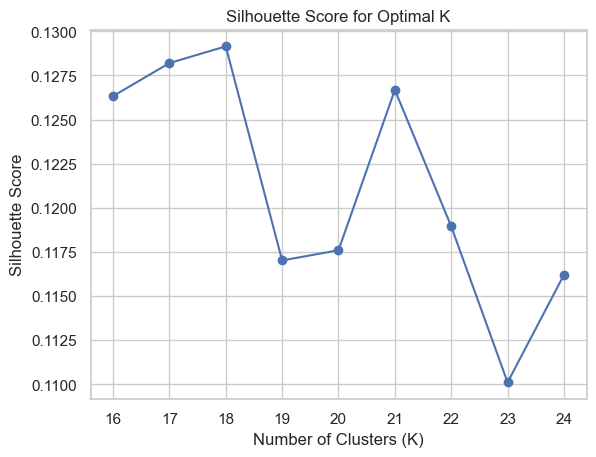

In [ ]:
# 尝试不同的K值
k_values = range(16, 25)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 绘制K值和轮廓系数之间的关系图
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

In [ ]:
# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 18  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data.data.numpy())

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

/Users/yangqi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


聚类结果统计信息:
1     1629
5     1360
14    1060
8      847
12     802
3      541
11     391
0      371
9      367
7      330
6      283
10     255
16     221
2      212
17     158
4      144
15     112
13     107
Name: cluster_labels, dtype: int64
Adjusted Rand Score: 0.1997


## 最终确定的损失函数
最终的损失函数由四项组成，这里我们采用的超参数其实可以通过一定的方法得到最优的解，但由于计算量较大，小组成员的设备限制，并未求出最适合的超参数，而是根据经验值确立了几个较好的参数
Sparsity Loss (稀疏性损失):这部分损失通常用于鼓励模型的激活值变得稀疏，即大多数激活值为零。这有助于模型学习更加有用和紧凑的特征表示。
Adversarial Loss (对抗性损失):
对抗性损失是由生成对抗网络（GAN）中的判别器产生的损失。它推动模型生成更逼真的数据，以欺骗判别器。这通常用于生成对抗性训练，其中生成器试图生成与真实数据分布相似的样本。
Reconstruction Loss (重构损失):
重构损失是自编码器中的核心部分，表示模型在输入数据上的重建质量。它测量模型重建输入数据的能力。在训练过程中，模型被要求尽可能准确地还原原始输入。
KL Divergence (KL散度):
KL散度用于测量两个概率分布之间的差异。在自编码器的上下文中，KL散度通常用于测量模型学到的潜在变量分布与某个先验分布之间的差异，以鼓励学到的分布尽量接近先验分布。
对于超参数的选择，这取决于具体的任务和模型结构。一般来说，这些超参数的选择可能需要通过实验和交叉验证来确定。然而，有一些一般的指导原则：
Sparsity Loss的权重（0.1）： 控制稀疏性损失在总损失中的相对权重。较小的值会减弱对稀疏性的强调。
Adversarial Loss的权重（0.9）： 控制对抗性损失在总损失中的相对权重。这决定了对抗性训练对模型的影响程度。
Reconstruction Loss的权重（0.2）： 控制重构损失在总损失中的相对权重。较大的值会强调模型对输入数据的准确还原。
KL Divergence的权重（0.001）： 控制KL散度在总损失中的相对权重。通常，这个值相对较小，以确保潜在变量学到的分布不会偏离先验分布太远。
### 最终我们得到了0.3608的好结果

In [65]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import SpectralClustering
from minisom import MiniSom
import scanpy as sc
from sklearn.mixture import GaussianMixture
import torch.nn.functional as F

# 忽略所有警告
warnings.filterwarnings("ignore")

# 读取H5AD文件
file_path = r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad'  # 替换为你的H5AD文件路径
adata = sc.read(file_path)
print(adata.obs_keys())

# 获取细胞类型标签和其对应的数量
cell_type_counts = adata.obs['cell_type'].value_counts()

# 输出每个细胞类型及其对应的数量
print("细胞类型及数量:")
print(cell_type_counts)

class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, l2_reg=1e-5,sparsity_penalty=1e-3):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(True))
        self.discriminator = nn.Sequential(
            nn.Linear(encoding_dim, 1),
            nn.Sigmoid()
        )

        # 定义均值和方差的全连接层
         # 添加 L2 正则化
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        # 添加稀疏性惩罚
        self.sparsity_penalty = sparsity_penalty
    def forward(self, x):
         # 编码器
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # 解码器
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
   

    def forward(self, x):
        # 获取 encoder 输出
        x = self.encoder(x)
        # 提取均值和方差
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        #  重新参数化技巧
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # 获取 decoder 输出
        x_reconstructed = self.decoder(z)
    
          # 获取 discriminator 输出
        validity = self.discriminator(encoded_data)
    
        # 添加稀疏性惩罚
        sparsity_loss = F.kl_div(F.log_softmax(validity, dim=-1), torch.tensor([0.5, 0.5]).to(validity.device), reduction='batchmean')
        

        # 返回一个包含四个元素的元组
        return x_reconstructed, encoded_data,validity, sparsity_loss,  mu, logvar



def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence    


#数据预处理
def prepare_data(adata, n_components=30):
    # 如果数据是稀疏的，转换为密集矩阵
    if sp.issparse(adata.X):
        data = adata.X.todense()
    else:
        data = adata.X
    
    # 转换为np.array类型
    data = np.asarray(data)
    
    # 对数变换
    data = np.log1p(data)
    
    # 标准化数据
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # 归一化数据
    minmax_scaler = MinMaxScaler()
    data = minmax_scaler.fit_transform(data)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
  
    return torch.tensor(data, dtype=torch.float)
# 定义判别器模型
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# 读取.h5ad文件
adata = anndata.read_h5ad(r'D:\dasanshang\jiqixuexi\final\dataset2.h5ad')

# 数据准备
data = prepare_data(adata)
input_dim = data.shape[1]
encoding_dim = 128  # 可以根据需要调整
# 创建 AdversarialAutoencoder 模型
adversarial_autoencoder = AdversarialAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
# 定义损失函数和优化器
criterion = nn.MSELoss()
criterion_adversarial = torch.nn.BCELoss()
optimizer = Adam(adversarial_autoencoder.parameters(), lr=1e-3,weight_decay=1e-5)
num_epochs = 300
discriminator = Discriminator(input_dim)
# 假设真实数据和生成数据
real_data = torch.randn((9190, input_dim))  # 这里 batch_size 是你的批大小

# 计算判别器对真实数据和生成数据的输出
validity_real = discriminator(real_data)
validity_fake = discriminator(data)
for epoch in range(num_epochs):
    # 前向传播
    reconstructed_data,encoded_data,validity,sparsity_loss ,mu, logvar = adversarial_autoencoder(data)  
    # 生成相应大小的标签张量,encoded_data,validity,sparsity_loss
    target_real = torch.ones_like(validity)  # 对抗性输出的真实标签是1
    target_fake = torch.zeros_like(validity)  # 对抗性输出的虚假标签是0
  
    # 计算对抗性损失
    adversarial_loss_real = criterion_adversarial(validity_real, target_real)
    adversarial_loss_fake = criterion_adversarial(validity_fake, target_fake)

    # 总的对抗性损失
    adversarial_loss = adversarial_loss_real + adversarial_loss_fake
    
    # reconstructed_data,encoded_data, mu=adversarial_autoencoder(data) 
    # 计算重构误差和KL散度项
    reconstruction_loss = criterion(reconstructed_data, data)
    kl_divergence = calculate_kl_divergence(mu, logvar)  # 请确保定义了 calculate_kl_divergence 函数    
    criterion_adversarial = nn.BCELoss()
   
    # 总损失为重构误差加上 KL 散度项
    #loss = reconstruction_loss + kl_divergence*0.1
    loss = 0.1*sparsity_loss+adversarial_loss*0.9+reconstruction_loss*0.2 + kl_divergence*0.001
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()    
    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# 将模型切换到评估模式
adversarial_autoencoder.eval()

# 获取降维后的数据
# 假设 encoder 返回一个包含三个元素的元组
_, encoded_data, _, _, _,_ = adversarial_autoencoder(data)

print(data.shape)

# 输出降维后的数据形状
print("降维后的数据形状:", encoded_data.shape)

num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

# 将数据转换为numpy数组
data_array = encoded_data.data.numpy()

# 创建 GMM 模型
gmm = GaussianMixture(n_components=num_clusters, random_state=42)

# 在数据上训练 GMM
gmm.fit(data_array)

# 获取每个数据点的聚类标签
cluster_labels = gmm.predict(data_array)

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 计算UMAP
#sc.tl.umap(adata)

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

['domain', 'cell_type']
细胞类型及数量:
E2Rasgrf2     2254
E3Rorb        1443
E6Tle4        1186
E4Il1rapl2     620
E5Galnt14      532
E4Thsd7a       470
Ast            444
E5Parm1        345
InP            274
OliM           270
E3Rmst         231
E5Sulf1        223
InS            206
Clau           146
InV            129
InN            100
OPC             98
E5Tshz2         85
Mic             63
OliI            30
Endo            22
Peri            19
Name: cell_type, dtype: int64
Epoch [10/300], Loss: 8.3733, Reconstruction Loss: 0.5965, KL Divergence: 7033.3643
Epoch [20/300], Loss: 5.2788, Reconstruction Loss: 0.5630, KL Divergence: 3945.5164
Epoch [30/300], Loss: 3.8289, Reconstruction Loss: 0.5339, KL Divergence: 2501.4326
Epoch [40/300], Loss: 3.0453, Reconstruction Loss: 0.5118, KL Divergence: 1722.3364
Epoch [50/300], Loss: 2.5995, Reconstruction Loss: 0.4971, KL Divergence: 1279.4231
Epoch [60/300], Loss: 2.3189, Reconstruction Loss: 0.4891, KL Divergence: 1000.4705
Epoch [70/300],

**使用GMM算法来代替Kmeans聚类算法**

dataset2数据集本身获取的真实细胞类型数为22，这里同样使用22来测试效果。

In [ ]:
# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 22  # 调整聚类簇的数量，可以根据需要进行调整

# 将数据转换为numpy数组
data_array = encoded_data.data.numpy()

# 创建 GMM 模型
gmm = GaussianMixture(n_components=num_clusters, random_state=42)

# 在数据上训练 GMM
gmm.fit(data_array)

# 获取每个数据点的聚类标签
cluster_labels = gmm.predict(data_array)

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

聚类结果统计信息:
cluster_labels
0     894
2     890
21    814
16    698
15    609
19    594
7     501
8     472
3     410
4     397
17    363
14    346
10    344
6     313
12    253
13    250
9     238
20    228
18    209
1     140
11    133
5      94
Name: count, dtype: int64
Adjusted Rand Score: 0.3383


## 使用UMAP将经过降维的数据可视化

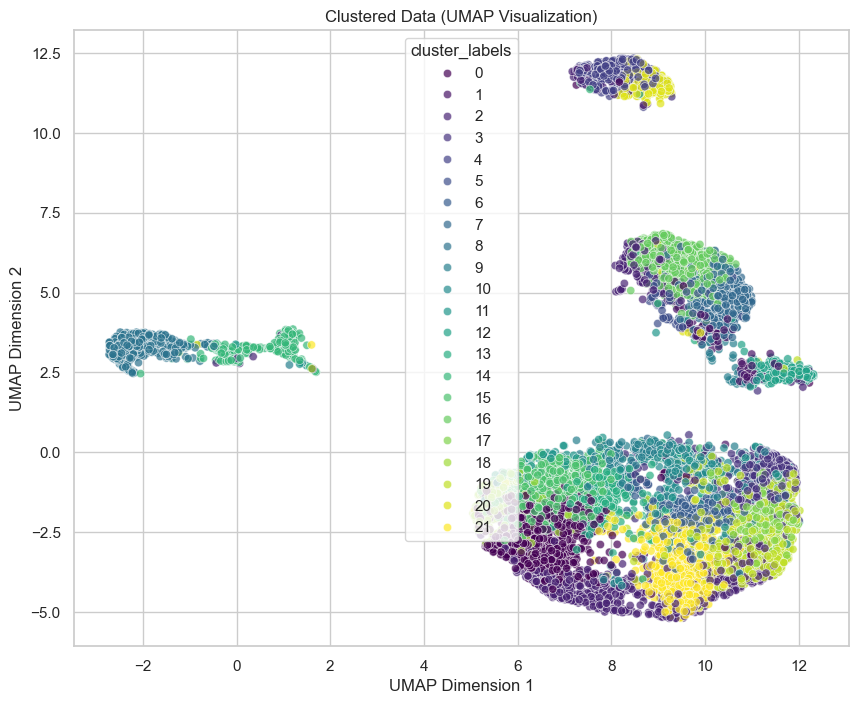

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 将 PyTorch 张量转换为 NumPy 数组
encoded_data_np = encoded_data.detach().numpy()

# 使用UMAP将高维数据映射到二维空间
umap_model = umap.UMAP()
umap_data = umap_model.fit_transform(encoded_data_np)

# 设置图形的风格
sns.set(style="whitegrid")

# 绘制UMAP可视化图像
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=adata.obs['cluster_labels'], palette='viridis', legend='full', alpha=0.7)
plt.title('Clustered Data (UMAP Visualization)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

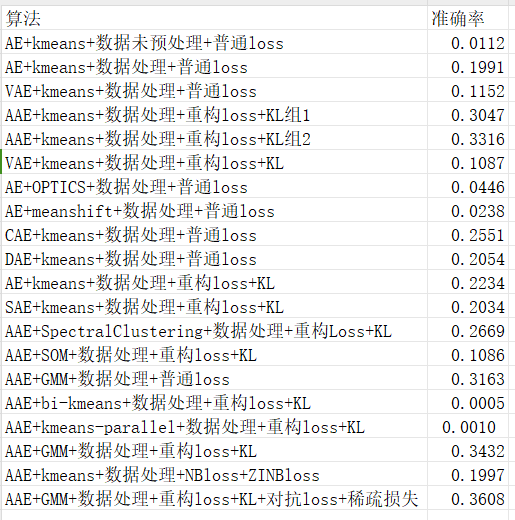

In [ ]:
# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 18  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data.data.numpy())

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

/Users/yangqi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


聚类结果统计信息:
1     1629
5     1360
14    1060
8      847
12     802
3      541
11     391
0      371
9      367
7      330
6      283
10     255
16     221
2      212
17     158
4      144
15     112
13     107
Name: cluster_labels, dtype: int64
Adjusted Rand Score: 0.1997


In [ ]:
# 使用K均值聚类对降维后的数据进行聚类
num_clusters = 18  # 调整聚类簇的数量，可以根据需要进行调整

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data.data.numpy())

# 将聚类结果添加到原始Scanpy对象中
adata.obs['cluster_labels'] = cluster_labels

# 输出聚类的统计信息
print("聚类结果统计信息:")
print(adata.obs['cluster_labels'].value_counts())

# Calculate Adjusted Rand Score
true_labels = adata.obs['cell_type']  # 替换为实际的真实标签
ari = adjusted_rand_score(true_labels, cluster_labels)

# 打印调整后的兰德指数
print(f'Adjusted Rand Score: {ari:.4f}')

/Users/yangqi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


聚类结果统计信息:
1     1629
5     1360
14    1060
8      847
12     802
3      541
11     391
0      371
9      367
7      330
6      283
10     255
16     221
2      212
17     158
4      144
15     112
13     107
Name: cluster_labels, dtype: int64
Adjusted Rand Score: 0.1997


#### 最终我们选择了AAE自动编码器，GMM聚类的方法，PCA降维，稀疏性损失+对抗性损失+重构损失+KL散度作为loss函数来搭建本次大作业的深度学习神经网络，最终得到了接近0.4的正确率，可以说是一个较好的分类结果。
## ***最后，也非常感谢卫老师和助教们这一个学期的照顾，祝我们都 `前程似锦` !🎉***